# Imports & Setup

In [1]:
!pip install -q filterpy cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 87.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from filterpy.kalman import ExtendedKalmanFilter
from pyproj import Transformer
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from abc import ABC, abstractmethod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Constants
MIN_LENGTH = 18  # Minimum storm track length
DT = 3.0  # Time step in hours
STATE_DIM = 6  # [x, y, vx, vy, ax, ay]
MEAS_DIM = 2   # [x, y]
INIT_OBSERVATIONS = 8  # Use 8 observations for initialization (24 hours)

# Utility Functions

In [4]:
# Projection transformers
proj_transformer = Transformer.from_crs(
    "EPSG:4326",
    "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40 +lon_0=-50 +units=km",
    always_xy=True
)
inverse_transformer = Transformer.from_crs(
    "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40 +lon_0=-50 +units=km",
    "EPSG:4326",
    always_xy=True
)

In [5]:
def convert_positions_to_km(positions_deg):
    """Convert array of (lon, lat) positions from degrees to km"""
    positions_km = []
    for lon, lat in positions_deg:
        x_km, y_km = proj_transformer.transform(lon, lat)
        positions_km.append([x_km, y_km])
    return np.array(positions_km)

In [6]:
def convert_positions_to_deg(positions_km):
    """Convert array of (x, y) positions from km to degrees"""
    positions_deg = []
    for x, y in positions_km:
        lon, lat = inverse_transformer.transform(x, y)
        positions_deg.append([lon, lat])
    return np.array(positions_deg)

# Data Loading

In [7]:
# Dataset URL
URL = (
    "https://www.ncei.noaa.gov/data/"
    "international-best-track-archive-for-climate-stewardship-ibtracs/"
    "v04r00/access/csv/ibtracs.NA.list.v04r00.csv"
)

In [8]:
class IBTrACSDataLoader:
    """Handles loading and preprocessing of IBTrACS storm data"""

    def __init__(self, url=URL, min_length=MIN_LENGTH):
        self.url = url
        self.min_length = min_length
        self.df = None
        self.storm_metadata = {}

    def load_and_preprocess(self):
        """Load and preprocess storm data"""
        # Load data
        self.df = pd.read_csv(self.url, low_memory=False)
        print(f"Loaded {len(self.df):,} records")

        # Remove units row
        self.df = self.df[1:].reset_index(drop=True)

        # Convert columns to numeric
        numeric_cols = [
            'LAT',
            'LON',
            'SEASON',
            'STORM_SPEED',
            'STORM_DIR',
            'DIST2LAND',
            'NUMBER'
        ]
        for col in numeric_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

        # Clean coordinates
        self.df = self.df.dropna(subset=['LAT', 'LON'])
        self.df = self.df[(self.df['LAT'].abs() <= 90) & (self.df['LON'].abs() <= 180)]

        # Parse dates
        self.df['ISO_TIME'] = pd.to_datetime(self.df['ISO_TIME'])
        self.df['YEAR'] = self.df['ISO_TIME'].dt.year

        # Filter pre-1900 storms
        self.df = self.df[self.df['YEAR'] >= 1900].copy()

        # Filter storms by minimum length
        counts = self.df['SID'].value_counts()
        valid_sids = counts[counts >= self.min_length].index
        self.df = self.df[self.df['SID'].isin(valid_sids)].copy()

        # Filter storms with missing STORM_SPEED or STORM_DIR
        storms_with_missing = self.df[
            self.df['STORM_SPEED'].isna() | self.df['STORM_DIR'].isna()
        ]['SID'].unique()

        if len(storms_with_missing) > 0:
            print(f"Removing {len(storms_with_missing)} storms with missing speed/direction data")
            self.df = self.df[~self.df['SID'].isin(storms_with_missing)]

        # Rename columns
        self.df.rename(columns={'LON': 'x', 'LAT': 'y'}, inplace=True)

        # Ensure data is properly sorted
        self.df.sort_values(['SID', 'ISO_TIME'], inplace=True)

        # Extract storm metadata
        self._extract_metadata()

        print(f"After preprocessing: {len(self.df):,} records")
        print(f"Number of valid storms: {self.df['SID'].nunique()}")

        return self.df

    def _extract_metadata(self):
        """Extract storm metadata"""
        self.storm_metadata['start_time'] = self.df.groupby('SID')['ISO_TIME'].min().to_dict()
        self.storm_metadata['year'] = self.df.groupby('SID')['YEAR'].first().astype(int).to_dict()

    def split_by_year(self, test_year):
        """Split data into train/test based on year"""
        train_sids = [sid for sid, year in self.storm_metadata['year'].items()
                      if year < test_year]
        test_sids = [sid for sid, year in self.storm_metadata['year'].items()
                     if year == test_year]

        df_train = self.df[self.df['SID'].isin(train_sids)]
        df_test = self.df[self.df['SID'].isin(test_sids)]

        return train_sids, test_sids, df_train, df_test

In [9]:
# Load and preprocess the dataset
loader = IBTrACSDataLoader()
df = loader.load_and_preprocess()

Loaded 126,971 records
After preprocessing: 87,013 records
Number of valid storms: 1464


In [10]:
# View all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Isolate columns we want to view
df_view = df[[
    'SID',
    'YEAR',
    'ISO_TIME',
    'x',
    'y',
    'NUMBER',
    'STORM_SPEED',
    'STORM_DIR',
    'DIST2LAND',
    'TRACK_TYPE',
    'NATURE'
]]

# Rename x and y
df_view.rename(columns={'x': 'LON', 'y': 'LAT'}, inplace=True)

# Sort by SID and ISO_TIME
df_view.sort_values(['SID', 'ISO_TIME'], inplace=True)

# Get 5 random storms
np.random.seed(42)
random_storms = df_view['SID'].unique()
selected_storms = np.random.choice(random_storms, size=5, replace=False)

# Get all data for these 5 storms
df_view_5 = df_view[df_view['SID'].isin(selected_storms)]

# Sample 5 rows from each of the 5 storms
df_view_5_sampled = df_view[df_view['SID'].isin(selected_storms)].groupby('SID').apply(
    lambda x: x.sample(min(5, len(x)))
).reset_index(drop=True)

print("All data for 5 random storms:")
display(df_view_5)  # All rows from 5 random storms
print("\n5 rows of data for 5 random storms:")
display(df_view_5_sampled)  # Up to 5 rows from each of the 5 random storms

All data for 5 random storms:


,SID,YEAR,ISO_TIME,LON,LAT,NUMBER,STORM_SPEED,STORM_DIR,DIST2LAND,TRACK_TYPE,NATURE
48293,1924257N24276,1924,1924-09-13 00:00:00,-84.5000,24.0000,33,12.0,312.0,154,main,TS
48294,1924257N24276,1924,1924-09-13 03:00:00,-84.9919,24.4102,33,12.0,311.0,215,main,TS
48295,1924257N24276,1924,1924-09-13 06:00:00,-85.5000,24.8000,33,12.0,309.0,279,main,TS
48296,1924257N24276,1924,1924-09-13 09:00:00,-86.0227,25.1575,33,11.0,308.0,345,main,TS
48297,1924257N24276,1924,1924-09-13 12:00:00,-86.5000,25.5000,33,10.0,312.0,402,main,TS
48298,1924257N24276,1924,1924-09-13 15:00:00,-86.8878,25.8498,33,9.0,318.0,418,main,TS
48299,1924257N24276,1924,1924-09-13 18:00:00,-87.2000,26.2000,33,9.0,322.0,364,main,TS
48300,1924257N24276,1924,1924-09-13 21:00:00,-87.4876,26.5500,33,8.0,327.0,320,main,TS
48301,1924257N24276,1924,1924-09-14 00:00:00,-87.7000,26.9000,33,8.0,337.0,271,main,TS
48302,1924257N24276,1924,1924-09-14 03:00:00,-87.8302,27.2574,33,7.0,346.0,228,main,TS



5 rows of data for 5 random storms:


,SID,YEAR,ISO_TIME,LON,LAT,NUMBER,STORM_SPEED,STORM_DIR,DIST2LAND,TRACK_TYPE,NATURE
0,1924257N24276,1924,1924-09-15 12:00:00,-85.5000,29.6000,33,6.0,62.0,14,main,TS
1,1924257N24276,1924,1924-09-16 00:00:00,-84.3000,30.2000,33,6.0,63.0,0,main,TS
2,1924257N24276,1924,1924-09-13 00:00:00,-84.5000,24.0000,33,12.0,312.0,154,main,TS
3,1924257N24276,1924,1924-09-14 21:00:00,-87.3300,28.8074,33,7.0,53.0,167,main,TS
4,1924257N24276,1924,1924-09-13 18:00:00,-87.2000,26.2000,33,9.0,322.0,364,main,TS
5,1934275N26322,1934,1934-10-03 09:00:00,-47.5075,30.7348,62,11.0,296.0,1836,main,TS
6,1934275N26322,1934,1934-10-02 06:00:00,-42.5000,29.0000,62,11.0,302.0,2167,main,TS
7,1934275N26322,1934,1934-10-03 03:00:00,-46.2929,30.3348,62,11.0,286.0,1909,main,TS
8,1934275N26322,1934,1934-10-02 00:00:00,-41.3000,28.3000,62,14.0,307.0,2285,main,TS
9,1934275N26322,1934,1934-10-02 12:00:00,-43.5000,29.5000,62,10.0,296.0,2080,main,TS


# Data Exploration

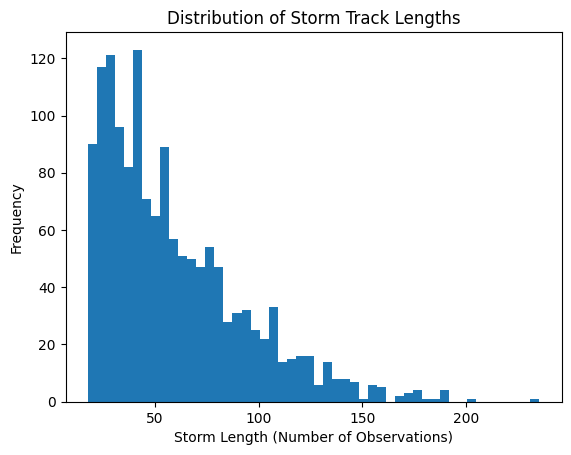


Mean storm length: 59.44
Median storm length: 51.0
Max storm length: 235
Min storm length: 18


In [11]:
# Plot the distribution of track lengths
storm_lengths = df.groupby('SID')['ISO_TIME'].count()
plt.hist(storm_lengths, bins=50)
plt.xlabel('Storm Length (Number of Observations)')
plt.ylabel('Frequency')
plt.title('Distribution of Storm Track Lengths')
plt.show()

print(f"\nMean storm length: {storm_lengths.mean():.2f}")
print(f"Median storm length: {storm_lengths.median()}")
print(f"Max storm length: {storm_lengths.max()}")
print(f"Min storm length: {storm_lengths.min()}")

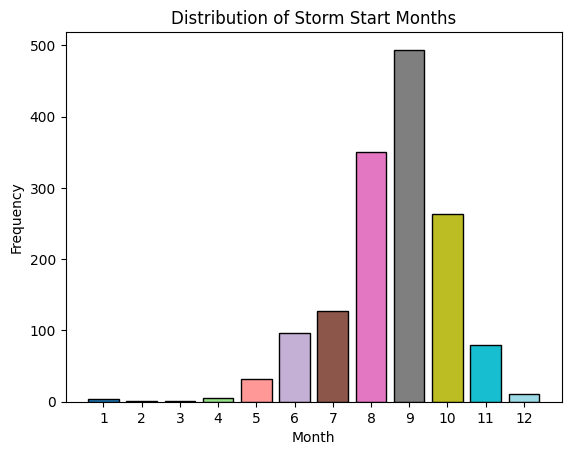

In [12]:
# Get storm start months
df['START_MONTH'] = df['ISO_TIME'].dt.month
start_months = df.groupby('SID')['START_MONTH'].first()

# Plot the distribution
bins = np.arange(0.5, 13.5, 1)
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, 12))
counts, edges, patches = plt.hist(
    start_months,
    bins=bins,
    rwidth=0.8,
    edgecolor='black'
)

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Storm Start Months')
plt.show()

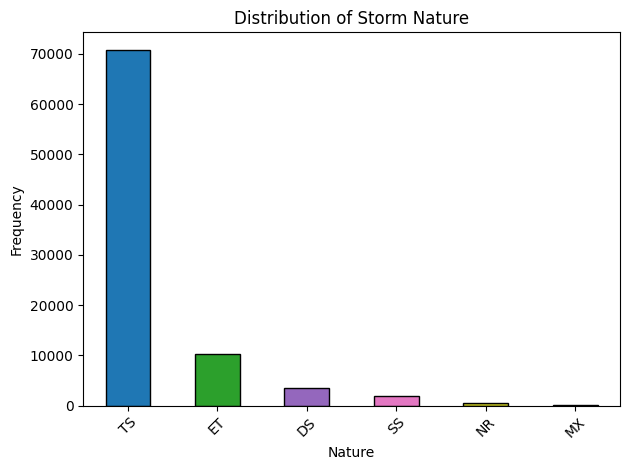

In [13]:
# Plot the distribution of NATURE
counts = df['NATURE'].value_counts()
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(counts)))

counts.plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    rot=45
)

plt.xlabel('Nature')
plt.ylabel('Frequency')
plt.title('Distribution of Storm Nature')
plt.tight_layout()
plt.show()

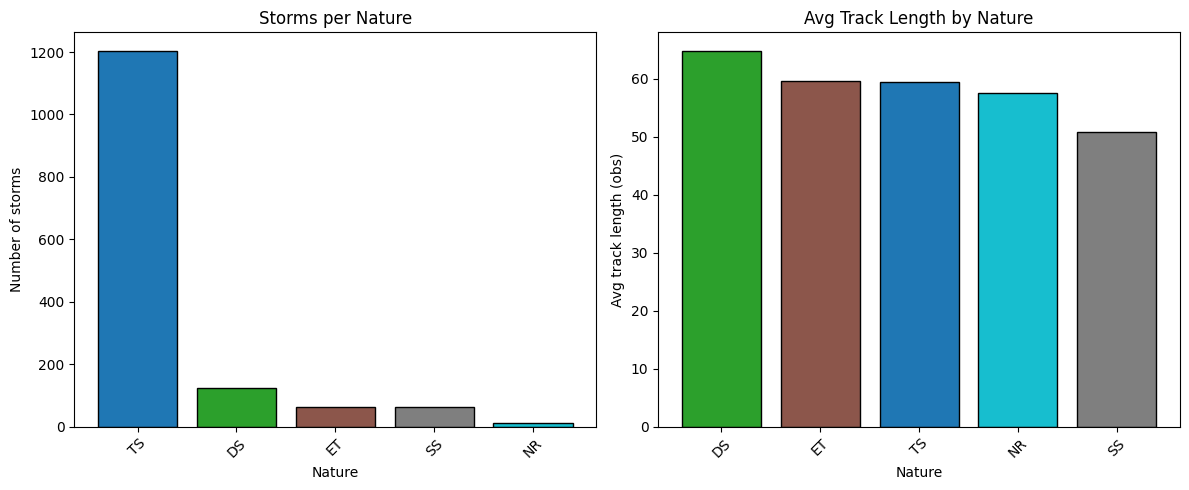

In [14]:
# Build a storm_info table with one row per storm
storm_info = (df.groupby('SID').agg(nature=('NATURE', 'first'), length=('ISO_TIME', 'count')))

# Count storms by nature
storm_counts = storm_info['nature'].value_counts()

# Compute average track length by nature
avg_lengths = storm_info.groupby('nature')['length'].mean()

# Sort by descending count
counts_order = storm_counts.sort_values(ascending=False).index
lengths_order = avg_lengths.sort_values(ascending=False).index

# Build a fixed color for each nature
cmap = plt.get_cmap('tab10')
base_colors = cmap(np.linspace(0, 1, len(counts_order)))
color_map = dict(zip(counts_order, base_colors))

# Prepare the colors in bar‑order for each plot
count_colors = [color_map[n] for n in counts_order]
length_colors = [color_map[n] for n in lengths_order]

# Re-index both series in the desired order
storm_counts_ord = storm_counts.loc[counts_order]
avg_lengths_ord = avg_lengths.loc[lengths_order]

# Plot number of storms by nature
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].bar(
    storm_counts_ord.index,
    storm_counts_ord.values,
    color=count_colors,
    edgecolor='black'
)
axes[0].set_xlabel('Nature')
axes[0].set_ylabel('Number of storms')
axes[0].set_title('Storms per Nature')
axes[0].tick_params(axis='x', rotation=45)

# Plot average track length by nature
axes[1].bar(
    avg_lengths_ord.index,
    avg_lengths_ord.values,
    color=length_colors,
    edgecolor='black'
)
axes[1].set_xlabel('Nature')
axes[1].set_ylabel('Avg track length (obs)')
axes[1].set_title('Avg Track Length by Nature')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

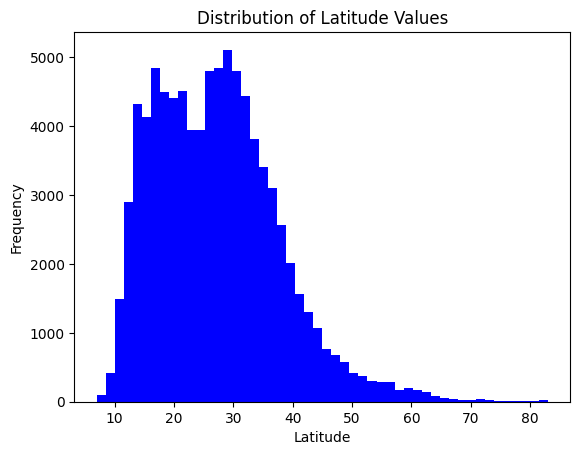

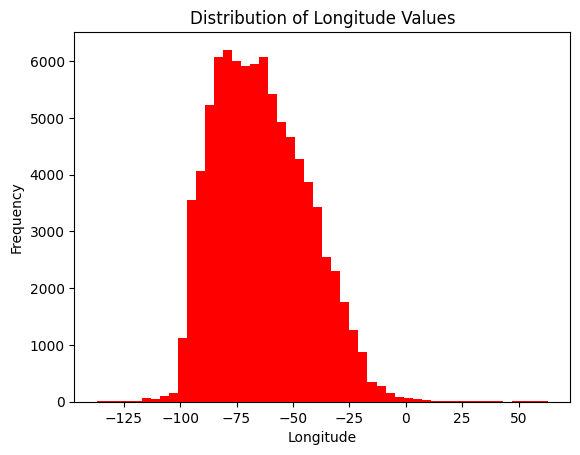

In [15]:
# Plot distibution of LAT values
plt.hist(df['y'], bins=50, color='b')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Distribution of Latitude Values')
plt.show()
print("\n")

# Plot distribution of LON values
plt.hist(df['x'], bins=50, color='r')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Distribution of Longitude Values')
plt.show()

In [16]:
def create_storm_track_density(df, grid_size=1.0):
    """Create storm track density using grid-based approach"""
    # Create spatial bins
    lon_min, lon_max = -100, -20
    lat_min, lat_max = 10, 50

    lon_bins = np.arange(lon_min, lon_max + grid_size, grid_size)
    lat_bins = np.arange(lat_min, lat_max + grid_size, grid_size)

    # Initialize density grid
    track_density = np.zeros((len(lat_bins)-1, len(lon_bins)-1))
    storm_count = np.zeros((len(lat_bins)-1, len(lon_bins)-1))

    # Process each storm
    for sid in df['SID'].unique():
        storm_data = df[df['SID'] == sid].sort_values('ISO_TIME')

        # Mark grid cells this storm passed through
        storm_cells = set()

        for _, point in storm_data.iterrows():
            lon_idx = np.digitize(point['x'], lon_bins) - 1
            lat_idx = np.digitize(point['y'], lat_bins) - 1

            # Check bounds
            if 0 <= lon_idx < len(lon_bins)-1 and 0 <= lat_idx < len(lat_bins)-1:
                track_density[lat_idx, lon_idx] += 1
                storm_cells.add((lat_idx, lon_idx))

        # Count unique storms per cell
        for lat_idx, lon_idx in storm_cells:
            storm_count[lat_idx, lon_idx] += 1

    return lon_bins, lat_bins, track_density, storm_count

In [17]:
def plot_track_density_map(df):
    """Create storm track density map"""
    # Calculate densities
    lon_bins, lat_bins, track_density, storm_count = create_storm_track_density(df, grid_size=1.0)

    # Create figure
    fig = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-100, -20, 10, 50], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.LAND, color='#E8E8E8', zorder=2)
    ax.add_feature(cfeature.OCEAN, color='#F0F8FF', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='#333333', zorder=3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.3, zorder=3)

    # Create meshgrid
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    LON, LAT = np.meshgrid(lon_centers, lat_centers)

    # Plot track density
    density_plot = ax.contourf(
        LON,
        LAT,
        storm_count,
        levels=[10, 20, 30, 40, 50, 60, 80, 100],
        cmap='Blues',
        alpha=0.8,
        transform=ccrs.PlateCarree(),
        extend='max'
    )

    # Colorbar
    cbar = plt.colorbar(
        density_plot,
        ax=ax,
        orientation='horizontal',
        pad=0.05,
        shrink=0.8,
        aspect=30
    )
    cbar.set_label('Number of Storms per 1 deg Grid Cell', fontsize=12)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False

    plt.title('Storm Track Density (1900-Present)', fontsize=16, pad=20)
    plt.tight_layout()
    return fig, storm_count, lon_bins, lat_bins

Creating track density map...


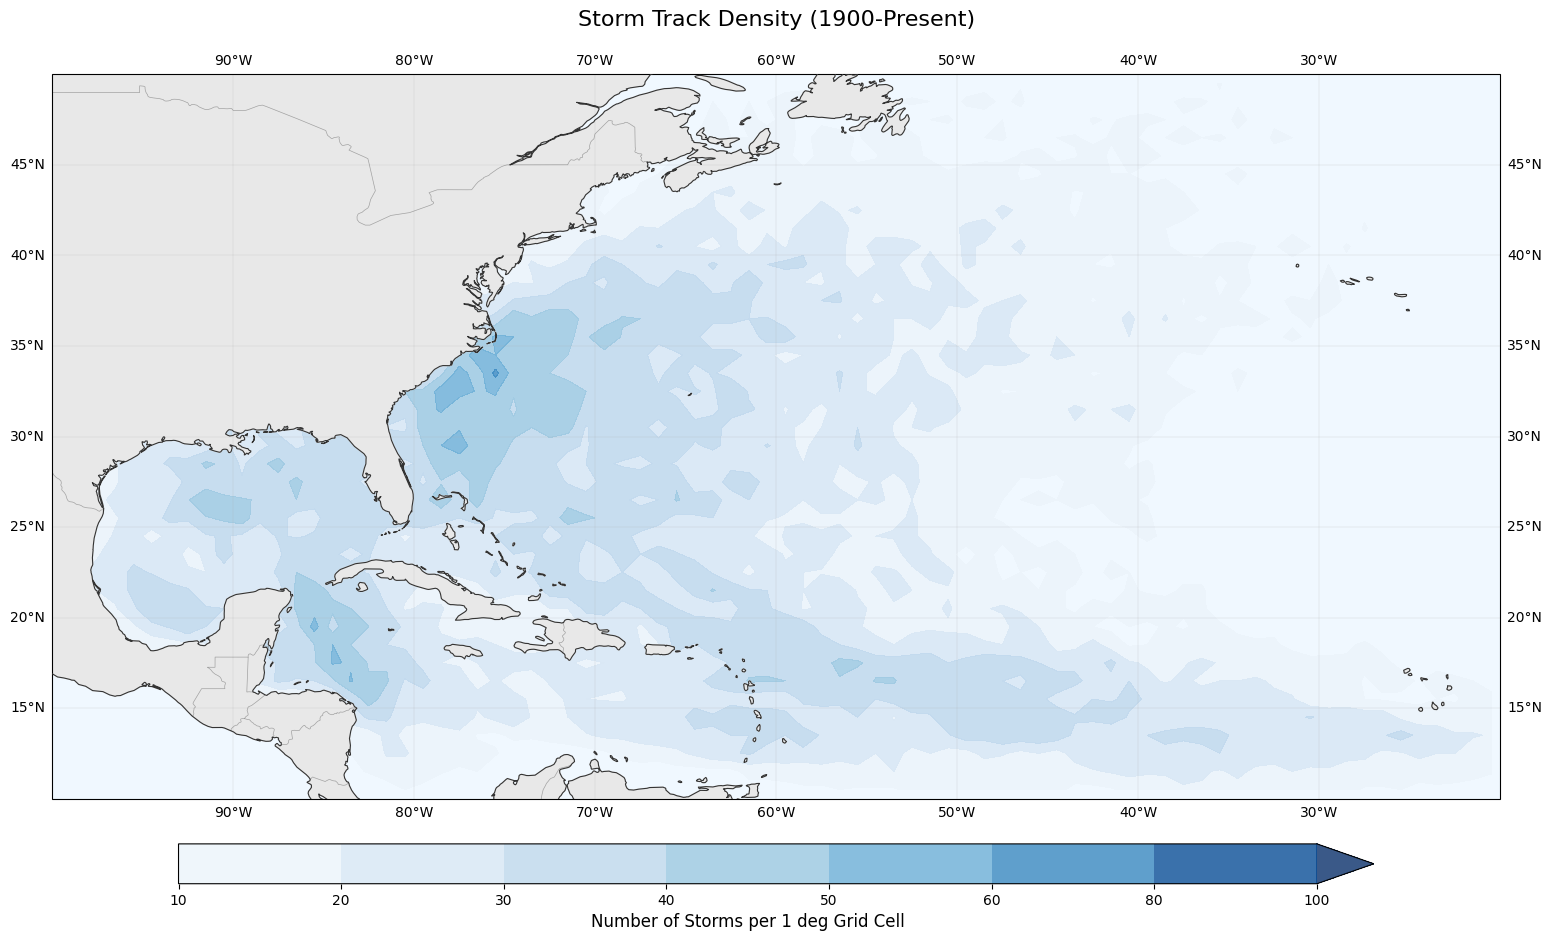

In [18]:
# Create track density map
print("Creating track density map...")
fig1, storm_count, lon_bins, lat_bins = plot_track_density_map(df)
plt.show()

In [19]:
def plot_genesis_density(df):
    """Create storm genesis density map"""
    # Get first observation of each storm
    genesis_points = df.groupby('SID').first().reset_index()

    # Create figure
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-100, -20, 10, 50], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.LAND, color='#E8E8E8')
    ax.add_feature(cfeature.OCEAN, color='#F0F8FF')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='#333333')

    # Create 2D histogram
    lon_bins = np.arange(-100, -20, 2.5)
    lat_bins = np.arange(10, 50, 2.5)

    H, _, _ = np.histogram2d(
        genesis_points['x'],
        genesis_points['y'],
        bins=[lon_bins, lat_bins]
    )

    # Plot heatmap
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    LON, LAT = np.meshgrid(lon_centers, lat_centers)

    # Only plot non-zero values
    H_masked = np.ma.masked_where(H.T <= 0, H.T)

    im = ax.pcolormesh(
        LON, LAT, H_masked,
        cmap='YlOrRd',
        alpha=0.8,
        transform=ccrs.PlateCarree(),
        vmin=1
    )

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Number of Storm Genesis Points', fontsize=12)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False

    plt.title('Storm Genesis Locations', fontsize=16, pad=20)
    plt.tight_layout()
    return fig

Creating genesis density map...


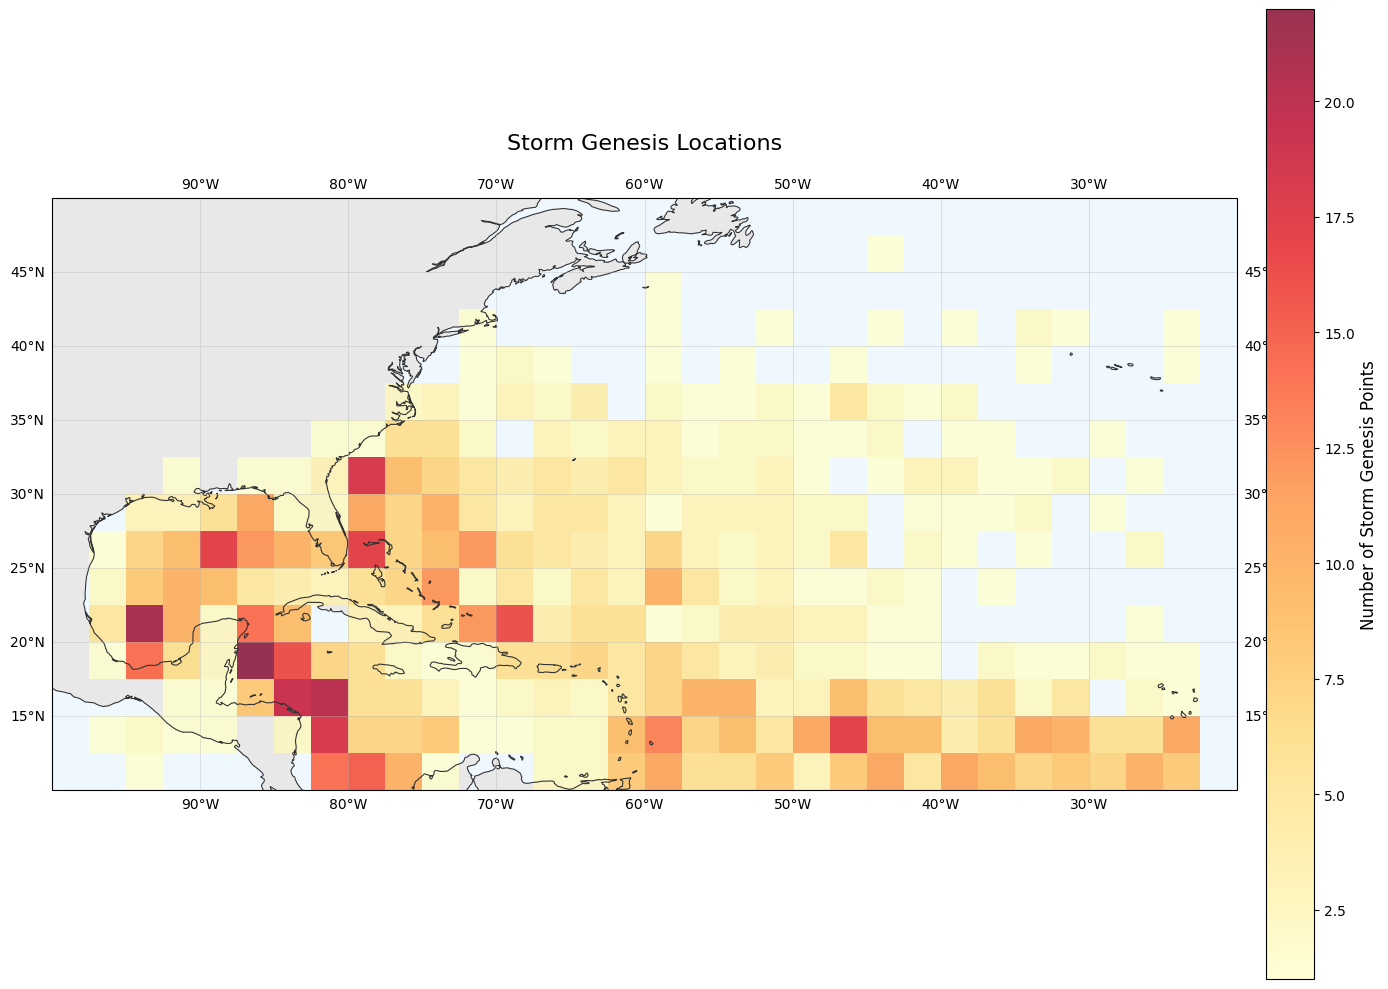

In [20]:
# Genesis density map
print("Creating genesis density map...")
fig2 = plot_genesis_density(df)
plt.show()

In [21]:
def identify_hotspot_regions(storm_count, lon_bins, lat_bins, min_storms=20):
    """Identify hotspot regions based on storm count"""
    hotspots = []

    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):
            if storm_count[i, j] >= min_storms:
                hotspots.append({
                    'lat_center': (lat_bins[i] + lat_bins[i+1]) / 2,
                    'lon_center': (lon_bins[j] + lon_bins[j+1]) / 2,
                    'storm_count': int(storm_count[i, j])
                })

    # Sort by storm count
    hotspots = sorted(hotspots, key=lambda x: x['storm_count'], reverse=True)
    return hotspots

In [22]:
# Find hotspots
hotspots = identify_hotspot_regions(storm_count, lon_bins, lat_bins, min_storms=25)

print(f"Top 10 Storm Hotspots (>=25 storms per 1 deg grid cell):")
print("-"*60)
print(f"{'Rank':<6} {'Latitude':<12} {'Longitude':<12} {'Storm Count':<12}")
print("-"*60)

for i, hs in enumerate(hotspots[:10], 1):
    print(f"{i:<6} {hs['lat_center']:<12.1f} {hs['lon_center']:<12.1f} {hs['storm_count']:<12}")

Top 10 Storm Hotspots (>=25 storms per 1 deg grid cell):
------------------------------------------------------------
Rank   Latitude     Longitude    Storm Count 
------------------------------------------------------------
1      33.5         -75.5        63          
2      34.5         -76.5        57          
3      29.5         -77.5        55          
4      32.5         -78.5        55          
5      32.5         -77.5        55          
6      33.5         -77.5        55          
7      19.5         -85.5        54          
8      31.5         -78.5        52          
9      35.5         -75.5        52          
10     16.5         -83.5        51          


In [23]:
def calculate_regional_summary(df, lon_bins, lat_bins):
    """Calculate regional storm statistics"""
    regions = {
        'US East Coast': {'lat': (30, 40), 'lon': (-80, -70)},
        'Gulf of Mexico': {'lat': (20, 30), 'lon': (-98, -80)},
        'Caribbean': {'lat': (10, 20), 'lon': (-85, -60)},
        'Central Atlantic': {'lat': (20, 35), 'lon': (-70, -50)},
        'Eastern Atlantic': {'lat': (10, 25), 'lon': (-50, -20)}
    }

    print("Regional Storm Activity Summary:")
    print("="*80)
    print(f"{'Region':<20} {'Unique Storms':<15} {'Total Observations':<20}")
    print("-"*80)

    for region_name, bounds in regions.items():
        # Find all observations in this region
        region_mask = (
            (df['y'] >= bounds['lat'][0]) &
            (df['y'] <= bounds['lat'][1]) &
            (df['x'] >= bounds['lon'][0]) &
            (df['x'] <= bounds['lon'][1])
        )

        region_data = df[region_mask]

        if len(region_data) > 0:
            unique_storms = region_data['SID'].nunique()
            total_obs = len(region_data)

            print(f"{region_name:<20} {unique_storms:<15} {total_obs:<20}\n")

In [24]:
# Regional summary
calculate_regional_summary(df, lon_bins, lat_bins)

Regional Storm Activity Summary:
Region               Unique Storms   Total Observations  
--------------------------------------------------------------------------------
US East Coast        410             5904                

Gulf of Mexico       519             11545               

Caribbean            483             9376                

Central Atlantic     606             13123               

Eastern Atlantic     392             9947                



# Model Development

In [25]:
# Determine test years
year_counts = df.groupby('YEAR')['SID'].nunique().sort_index()
available_years = sorted(df['YEAR'].unique())
test_years = [int(y) for y in available_years[-2:] if year_counts.get(y, 0) >= 5]
print(f"Test years selected: {test_years}")

Test years selected: [2022, 2023]


In [26]:
class StateTransitionModel(ABC):
    """Abstract base class for state transition models"""

    @abstractmethod
    def __call__(self, state, dt, exogenous=None):
        """Apply state transition"""
        pass

    @abstractmethod
    def jacobian(self, state, dt, exogenous=None):
        """Compute Jacobian of state transition"""
        pass

In [27]:
class StormStateTransition(StateTransitionModel):
    """State transition model for storm motion with exogenous variables"""

    def __init__(self, use_exogenous=True, alpha=0.3, delta=0.1):
        self.use_exogenous = use_exogenous
        self.decay_rate = 0.85
        self.beta_factor = 0.0005  # Beta drift factor
        self.alpha = alpha  # Blending factor for exogenous data
        self.delta = delta  # Finite difference step size for derivatives
        self._derivative_cache = {}  # Cache for projection derivatives
        self._cache_size_limit = 100000

    def __call__(self, state, dt, exogenous=None):
        """
        State transition with optional exogenous variables
        exogenous dict can contain: storm_speed, storm_dir, track_type, nature
        """
        x, y, vx, vy, ax, ay = state

        # Basic kinematics
        x_new = x + vx * dt + 0.5 * ax * dt**2
        y_new = y + vy * dt + 0.5 * ay * dt**2
        vx_new = vx + ax * dt
        vy_new = vy + ay * dt

        # Acceleration decay
        ax_new = ax * self.decay_rate
        ay_new = ay * self.decay_rate

        # Beta drift (poleward and westward tendency)
        # Use proper coordinate transformation
        lon_deg, lat_deg = inverse_transformer.transform(x, y)
        beta_effect = self.beta_factor * lat_deg
        vx_new -= beta_effect * dt
        vy_new += beta_effect * 0.5 * dt

        # Apply exogenous corrections if available
        if self.use_exogenous and exogenous is not None:
            # Use storm speed and direction if available
            if 'storm_speed' in exogenous and 'storm_dir' in exogenous:
                speed_kmh = exogenous['storm_speed'] * 1.852  # knots to km/h
                dir_rad = np.radians(exogenous['storm_dir'])

                # Blend observed motion with model
                obs_vx = speed_kmh * np.sin(dir_rad)  # East component
                obs_vy = speed_kmh * np.cos(dir_rad)  # North component

                vx_new = (1 - self.alpha) * vx_new + self.alpha * obs_vx
                vy_new = (1 - self.alpha) * vy_new + self.alpha * obs_vy

            # Adjust for storm nature (tropical vs. extratropical)
            if 'nature' in exogenous:
                if exogenous['nature'] == 'ET':  # Extratropical
                    # Extratropical storms move faster and more erratically
                    vx_new *= 1.1
                    vy_new *= 1.1

        results_array = np.array([
            x_new,
            y_new,
            vx_new,
            vy_new,
            ax_new,
            ay_new
        ])

        return results_array

    def _get_projection_derivatives(self, x, y):
        """Get projection derivatives using finite differences with caching"""
        # Cache key rounded to nearest 0.1 km
        cache_key = (round(x, 1), round(y, 1))

        if cache_key in self._derivative_cache:
            return self._derivative_cache[cache_key]

        # Check for extreme latitudes where projection may be problematic
        try:
            lon0, lat0 = inverse_transformer.transform(x, y)
        except:
            # Fallback for projection failures
            print(f"Warning: Projection failed at ({x:.1f}, {y:.1f})")
            result = (0.0, 1.0 / 111.0)
            self._derivative_cache[cache_key] = result
            return result

        # Use larger delta at extreme latitudes to improve numerical stability
        adjusted_delta = self.delta
        if abs(lat0) > 70:
            adjusted_delta = self.delta * 10
        elif abs(lat0) > 60:
            adjusted_delta = self.delta * 5
        elif abs(lat0) > 50:
            adjusted_delta = self.delta * 2

        # Compute derivatives using finite differences
        try:
            lon_dx, lat_dx = inverse_transformer.transform(x + adjusted_delta, y)
            lon_dy, lat_dy = inverse_transformer.transform(x, y + adjusted_delta)

            dlat_dx = (lat_dx - lat0) / adjusted_delta
            dlat_dy = (lat_dy - lat0) / adjusted_delta

            # Sanity check - derivatives should not be extreme
            max_derivative = 0.1  # Maximum reasonable value
            if abs(dlat_dx) > max_derivative or abs(dlat_dy) > max_derivative:
                print(f"Warning: Large derivatives at lat={lat0:.1f}: dlat_dx={dlat_dx:.4f}, dlat_dy={dlat_dy:.4f}")

            dlat_dx = np.clip(dlat_dx, -max_derivative, max_derivative)
            dlat_dy = np.clip(dlat_dy, -max_derivative, max_derivative)

        except Exception as e:
            # Fallback for projection failures at extreme coordinates
            print(f"Warning: Projection derivative failed at ({x:.1f}, {y:.1f}), lat={lat0:.1f}: {e}")
            dlat_dx = 0.0
            dlat_dy = 1.0 / 111.0  # Crude approximation

        result = (dlat_dx, dlat_dy)

        # Cache management
        if len(self._derivative_cache) >= self._cache_size_limit:
            self._derivative_cache.clear()
        self._derivative_cache[cache_key] = result

        return result

    def jacobian(self, state, dt, exogenous=None):
        """Jacobian of state transition with proper projection derivatives"""
        x, y, vx, vy, ax, ay = state

        # Get projection derivatives (uses proper transformation)
        dlat_dx, dlat_dy = self._get_projection_derivatives(x, y)

        # Start with basic kinematics Jacobian
        F = np.array([
            [1, 0, dt, 0, 0.5*dt**2, 0],
            [0, 1, 0, dt, 0, 0.5*dt**2],
            [0, 0, 1, 0, dt, 0],
            [0, 0, 0, 1, 0, dt],
            [0, 0, 0, 0, self.decay_rate, 0],
            [0, 0, 0, 0, 0, self.decay_rate]
        ])

        # Add beta drift derivatives
        # vx_new -= beta_factor * lat_deg * dt
        # dvx_new/dx = -beta_factor * dlat/dx * dt
        # dvx_new/dy = -beta_factor * dlat/dy * dt
        beta_dx_vx = -self.beta_factor * dlat_dx * dt
        beta_dy_vx = -self.beta_factor * dlat_dy * dt

        # vy_new += beta_factor * lat_deg * 0.5 * dt
        # dvy_new/dx = beta_factor * 0.5 * dlat/dx * dt
        # dvy_new/dy = beta_factor * 0.5 * dlat/dy * dt
        beta_dx_vy = self.beta_factor * 0.5 * dlat_dx * dt
        beta_dy_vy = self.beta_factor * 0.5 * dlat_dy * dt

        # Add beta drift terms to existing kinematics
        F[2, 0] += beta_dx_vx
        F[2, 1] += beta_dy_vx
        F[3, 0] += beta_dx_vy
        F[3, 1] += beta_dy_vy

        # Apply exogenous effects
        if self.use_exogenous and exogenous is not None:
            if 'storm_speed' in exogenous and 'storm_dir' in exogenous:
                # Alpha blending affects ALL contributions to velocity
                # vx_new = (1-alpha) * vx_new + alpha * obs_vx
                # This means all terms contributing to vx_new get scaled by (1-alpha)
                F[2, :] *= (1 - self.alpha)  # Scale entire vx row
                F[3, :] *= (1 - self.alpha)  # Scale entire vy row

            if 'nature' in exogenous and exogenous['nature'] == 'ET':
                # ET scaling is applied after alpha blending
                # This affects all contributions to velocities
                F[2, :] *= 1.1
                F[3, :] *= 1.1

        return F

    def validate_jacobian(
        self,
        state,
        dt,
        exogenous=None,
        epsilon=None,
        verbose=False
    ):
        """
        Validate Jacobian using finite differences

        Parameters:
        -----------
        state : array
            State vector to test at
        dt : float
            Time step
        exogenous : dict
            Exogenous variables
        epsilon : float or array
            Perturbation size(s) for finite differences. If None, auto-scale.
        verbose : bool
            Print detailed comparison

        Returns:
        --------
        dict with validation results
        """
        # Have epsilon default values
        if epsilon is None:
            epsilon = np.array([0.1, 0.1, 0.01, 0.01, 0.001, 0.001])
        elif np.isscalar(epsilon):
            # Do not use a single small epsilon for all components
            # Scale based on expected magnitudes
            base_eps = float(epsilon)
            epsilon = np.array([
                max(base_eps * 1000, 0.1),    # x position
                max(base_eps * 1000, 0.1),    # y position
                max(base_eps * 100, 0.01),    # x velocity
                max(base_eps * 100, 0.01),    # y velocity
                max(base_eps * 10, 0.001),    # x acceleration
                max(base_eps * 10, 0.001)     # y acceleration
            ])

        # Compute analytical Jacobian
        F_analytical = self.jacobian(state, dt, exogenous)

        # Compute numerical Jacobian via finite differences
        F_numerical = np.zeros_like(F_analytical)
        f0 = self(state, dt, exogenous)

        for i in range(len(state)):
            state_perturbed = state.copy()
            state_perturbed[i] += epsilon[i]
            f_perturbed = self(state_perturbed, dt, exogenous)
            F_numerical[:, i] = (f_perturbed - f0) / epsilon[i]

        # Compute differences
        abs_diff = np.abs(F_analytical - F_numerical)
        max_abs_diff = np.max(abs_diff)

        # Relative difference with proper handling of small values
        denominator = np.maximum(np.abs(F_analytical), np.abs(F_numerical))
        rel_diff = np.zeros_like(abs_diff)

        # Only compute relative difference where denominator is significant
        mask = denominator > 1e-10
        rel_diff[mask] = abs_diff[mask] / denominator[mask]

        # For very small values, use absolute difference threshold
        small_mask = ~mask
        rel_diff[small_mask] = np.where(abs_diff[small_mask] < 1e-10, 0, 1)

        max_rel_diff = np.max(rel_diff)

        # Check which entries have significant differences
        problem_indices = np.argwhere(rel_diff > 0.01)

        results = {
            'max_absolute_diff': max_abs_diff,
            'max_relative_diff': max_rel_diff,
            'mean_absolute_diff': np.mean(abs_diff),
            'mean_relative_diff': np.mean(rel_diff),
            'problem_indices': problem_indices,
            'is_valid': max_rel_diff < 0.01,  # 1% tolerance
            'F_analytical': F_analytical,
            'F_numerical': F_numerical,
            'absolute_diff_matrix': abs_diff,
            'relative_diff_matrix': rel_diff,
            'epsilon_used': epsilon
        }

        if verbose:
            print(f"\nJacobian Validation Results:")
            print(f"  Epsilon used: {epsilon}")
            print(f"  Max absolute difference: {max_abs_diff:.2e}")
            print(f"  Max relative difference: {max_rel_diff:.2%}")
            print(f"  Mean absolute difference: {results['mean_absolute_diff']:.2e}")
            print(f"  Mean relative difference: {results['mean_relative_diff']:.2%}")
            print(f"  Valid (< 1% relative error): {results['is_valid']}")

            if len(problem_indices) > 0:
                print(f"\n  Problem entries (> 1% relative error):")
                for idx in problem_indices[:10]:  # Show max 10 problems
                    i, j = idx
                    print(f"    F[{i},{j}]: analytical={F_analytical[i,j]:.6f}, "
                        f"numerical={F_numerical[i,j]:.6f}, "
                        f"rel_diff={rel_diff[i,j]:.2%}")

        return results

In [28]:
class EKFStormTracker(BaseEstimator, RegressorMixin):
    """
    Extended Kalman Filter for storm tracking with user-friendly API
    """

    def __init__(
        self,
        q_pos=4.0,
        q_vel=16.0,
        q_acc=9.0,
        r_pos=25.0,
        use_exogenous=True,
        init_observations=INIT_OBSERVATIONS,
        update_filter=True,
        update_freq=1
    ):
        self.q_pos = q_pos
        self.q_vel = q_vel
        self.q_acc = q_acc
        self.r_pos = r_pos
        self.use_exogenous = use_exogenous
        self.init_observations = init_observations
        self.update_filter = update_filter
        self.update_freq = update_freq

        # Components
        self.transition_model = StormStateTransition(use_exogenous)
        self.ekf = None

    def _initialize_ekf(self, initial_positions_km, storm_data=None):
        """Initialize EKF with state estimates using variance-based uncertainties"""
        self.ekf = ExtendedKalmanFilter(dim_x=STATE_DIM, dim_z=MEAS_DIM)

        # Initial position (use last observation)
        self.ekf.x = np.zeros(STATE_DIM)
        self.ekf.x[0] = initial_positions_km[-1, 0]
        self.ekf.x[1] = initial_positions_km[-1, 1]

        # Default variances (working in squared units)
        pos_var = 625.0               # 25^2 km^2
        vel_var = [10000.0, 10000.0]  # 100^2 (km/h)^2
        acc_var = 625.0               # 25^2 (km/h^2)^2

        # Estimate velocity and acceleration from observations
        if len(initial_positions_km) >= 3:
            # Calculate velocities between consecutive observations
            velocities = []
            for i in range(1, len(initial_positions_km)):
                v = (initial_positions_km[i] - initial_positions_km[i-1]) / DT
                velocities.append(v)
            velocities = np.array(velocities)

            # Set velocity state (weighted average, recent observations weighted higher)
            weights = np.exp(np.linspace(-1, 0, len(velocities)))
            weights /= weights.sum()
            avg_velocity = np.average(velocities, axis=0, weights=weights)
            self.ekf.x[2] = avg_velocity[0]
            self.ekf.x[3] = avg_velocity[1]

            # Velocity variance with minimum threshold
            vel_var = np.maximum(np.var(velocities, axis=0), 625.0)  # Min 25^2 (km/h)^2

            # Position variance tied to velocity variance and time step
            # sigma_x^2 = sigma_v^2 * Delta_t^2 (physics-based relationship)
            pos_var = np.mean(vel_var) * DT**2
            pos_var = max(pos_var, 100.0)  # Floor at 10^2 km^2

            # Estimate acceleration if we have enough velocity samples
            if len(velocities) >= 2:
                accelerations = []
                for i in range(1, len(velocities)):
                    a = (velocities[i] - velocities[i-1]) / DT
                    accelerations.append(a)
                accelerations = np.array(accelerations)

                # Set acceleration state
                avg_acceleration = np.mean(accelerations, axis=0)
                self.ekf.x[4] = avg_acceleration[0]
                self.ekf.x[5] = avg_acceleration[1]

                # Acceleration variance with minimum threshold
                if len(accelerations) > 1:
                    acc_var = max(np.mean(np.var(accelerations, axis=0)), 100.0)  # Min 10^2 (km/h^2)^2
                else:
                    acc_var = 400.0  # 20^2 (km/h^2)^2 for single estimate

        # Build covariance matrix directly from variances
        self.ekf.P = np.diag([
            pos_var,      # x variance
            pos_var,      # y variance
            vel_var[0],   # vx variance
            vel_var[1],   # vy variance
            acc_var,      # ax variance
            acc_var       # ay variance
        ])

        # Process noise (in variance units)
        self.ekf.Q = np.diag([
            self.q_pos,
            self.q_pos,
            self.q_vel,
            self.q_vel,
            self.q_acc,
            self.q_acc
        ])

        # Measurement noise (in variance units)
        self.ekf.R = np.diag([self.r_pos, self.r_pos])

    def _measurement_function(self, state):
        """Measurement function"""
        return state[:2]

    def _measurement_jacobian(self, state):
        """Measurement Jacobian"""
        H = np.zeros((2, 6))
        H[0, 0] = 1
        H[1, 1] = 1
        return H

    def _extract_exogenous(self, storm_data, time_idx):
        """Extract exogenous variables for current time"""
        if not self.use_exogenous or storm_data is None:
            return None

        row = storm_data.iloc[time_idx]
        exogenous = {}

        if 'STORM_SPEED' in row and not pd.isna(row['STORM_SPEED']):
            exogenous['storm_speed'] = row['STORM_SPEED']
        if 'STORM_DIR' in row and not pd.isna(row['STORM_DIR']):
            exogenous['storm_dir'] = row['STORM_DIR']
        if 'NATURE' in row:
            exogenous['nature'] = row['NATURE']
        if 'TRACK_TYPE' in row:
            exogenous['track_type'] = row['TRACK_TYPE']

        return exogenous if exogenous else None

    def predict_track(self, storm_data):
        """
        Predict storm track given storm data

        Parameters:
        -----------
        storm_data : DataFrame
            Storm observations with columns: x, y, ISO_TIME, and optional exogenous

        Returns:
        --------
        predictions : array
            Predicted positions in km
        errors : array
            Prediction errors in km (if full track available)
        """
        # Convert positions to km
        positions_km = convert_positions_to_km(storm_data[['x', 'y']].values)

        if len(positions_km) < self.init_observations + 1:
            return None, None

        # Initialize with first observations
        init_positions = positions_km[:self.init_observations]
        self._initialize_ekf(init_positions, storm_data[:self.init_observations])

        predictions = []
        errors = []

        # Sequential prediction
        for i in range(self.init_observations, len(positions_km)):
            # Extract exogenous variables
            exogenous = self._extract_exogenous(storm_data, i-1)

            # Predict
            F = self.transition_model.jacobian(self.ekf.x, DT, exogenous)  # Jacobian at prior state
            self.ekf.x = self.transition_model(self.ekf.x, DT, exogenous)  # Then transition
            self.ekf.P = F @ self.ekf.P @ F.T + self.ekf.Q

            # Store prediction
            pred_pos = self.ekf.x[:2].copy()
            predictions.append(pred_pos)

            # Calculate error if actual position available
            actual_pos = positions_km[i]
            error = np.linalg.norm(pred_pos - actual_pos)
            errors.append(error)

            # Update with measurement
            steps_since_init = i - self.init_observations + 1
            should_update = (self.update_filter and steps_since_init % self.update_freq == 0)

            if should_update:
                z = actual_pos
                y = z - self._measurement_function(self.ekf.x)
                H = self._measurement_jacobian(self.ekf.x)
                S = H @ self.ekf.P @ H.T + self.ekf.R

                try:
                    K = self.ekf.P @ H.T @ np.linalg.inv(S)
                    self.ekf.x = self.ekf.x + K @ y
                    self.ekf.P = (np.eye(STATE_DIM) - K @ H) @ self.ekf.P
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Warning: Singular matrix at step {i}, skipping update")

        return np.array(predictions), np.array(errors)

    def score(self, X, y=None):
        """Compute mean error across all storms"""
        all_errors = []
        for storm_data in X:
            _, errors = self.predict_track(storm_data)
            if errors is not None:
                all_errors.extend(errors)

        score_val = -np.mean(all_errors) if all_errors else -np.inf
        return score_val

In [29]:
def test_ekf_jacobian_validation():
    """Test Jacobian implementation across various conditions"""
    tracker = EKFStormTracker(use_exogenous=True)
    transition = tracker.transition_model

    print("=" * 60)
    print("EKF JACOBIAN VALIDATION TESTS")
    print("=" * 60)

    # Test case 1: Basic functionality with typical storm state
    print("\n1. Testing typical storm state...")
    state = np.array([1000.0, 500.0, 30.0, 20.0, 2.0, -1.0])  # Reasonable values

    print("   a) Without exogenous variables:")
    result = transition.validate_jacobian(state, DT, None, verbose=True)

    print("\n   b) With storm speed/direction:")
    exogenous = {'storm_speed': 25, 'storm_dir': 45}
    result = transition.validate_jacobian(state, DT, exogenous, verbose=True)

    print("\n   c) With ET storm:")
    exogenous_et = {'storm_speed': 30, 'storm_dir': 270, 'nature': 'ET'}
    result = transition.validate_jacobian(state, DT, exogenous_et, verbose=True)

    # Test case 2: Random states
    print("\n\n2. Testing random states...")
    n_random_tests = 20
    n_passed = 0
    n_failed = 0

    for i in range(n_random_tests):
        state = np.array([
            np.random.uniform(-5000, 5000),  # x
            np.random.uniform(-5000, 5000),  # y
            np.random.uniform(-50, 50),      # vx
            np.random.uniform(-50, 50),      # vy
            np.random.uniform(-5, 5),        # ax
            np.random.uniform(-5, 5)         # ay
        ])

        # Test without exogenous
        result = transition.validate_jacobian(state, DT, None)
        if result['is_valid']:
            n_passed += 1
        else:
            n_failed += 1
            print(f"   Test {i+1} failed without exogenous: max error {result['max_relative_diff']:.2%}")

        # Test with exogenous
        exogenous = {
            'storm_speed': np.random.uniform(10, 50),
            'storm_dir': np.random.uniform(0, 360)
        }
        result = transition.validate_jacobian(state, DT, exogenous)
        if not result['is_valid']:
            print(f"   Test {i+1} failed with exogenous: max error {result['max_relative_diff']:.2%}")

    print(f"   Random state tests: {n_passed}/{n_random_tests} passed")

    # Test case 3: Different latitudes (avoiding extreme values)
    print("\n\n3. Testing different latitudes...")
    latitudes = [-70, -60, -45, -30, -15, 0, 15, 30, 45]
    lat_results = []

    for lat in latitudes:
        lon = -50
        try:
            x, y = proj_transformer.transform(lon, lat)
            state = np.array([x, y, 30.0, 20.0, 2.0, -1.0])

            result = transition.validate_jacobian(state, DT, None)
            lat_results.append((lat, result['is_valid'], result['max_relative_diff']))

            status = "PASS" if result['is_valid'] else "FAIL"
            error_str = f"(max error: {result['max_relative_diff']:.2%})" if not result['is_valid'] else ""
            print(f"   Lat {lat:3d} degrees: {status} {error_str}")
        except Exception as e:
            print(f"   Lat {lat:3d} degrees: SKIP (projection error: {e})")
            lat_results.append((lat, False, np.inf))

    # Test case 4: Edge cases
    print("\n\n4. Testing edge cases...")

    print("   a) Zero velocity/acceleration:")
    state_zero = np.array([1000.0, 500.0, 0.0, 0.0, 0.0, 0.0])
    result = transition.validate_jacobian(state_zero, DT, None)
    print(f"      {'PASS' if result['is_valid'] else 'FAIL'} (max error: {result['max_relative_diff']:.2%})")

    print("   b) Large velocity:")
    state_fast = np.array([1000.0, 500.0, 200.0, 150.0, 10.0, -10.0])
    result = transition.validate_jacobian(state_fast, DT, None)
    print(f"      {'PASS' if result['is_valid'] else 'FAIL'} (max error: {result['max_relative_diff']:.2%})")

    print("   c) Near equator:")
    x_eq, y_eq = proj_transformer.transform(-50, 0)
    state_eq = np.array([x_eq, y_eq, 30.0, 20.0, 2.0, -1.0])
    result = transition.validate_jacobian(state_eq, DT, None)
    print(f"      {'PASS' if result['is_valid'] else 'FAIL'} (max error: {result['max_relative_diff']:.2%})")

    # Test case 5: Different time steps
    print("\n\n5. Testing different time steps...")
    time_steps = [1.0, 3.0, 6.0, 12.0]  # hours
    state = np.array([1000.0, 500.0, 30.0, 20.0, 2.0, -1.0])

    for dt_test in time_steps:
        result = transition.validate_jacobian(state, dt_test, None)
        status = "PASS" if result['is_valid'] else "FAIL"
        print(f"   dt = {dt_test:4.1f} hours: {status} (max error: {result['max_relative_diff']:.2%})")

    # Summary
    print("\n" + "=" * 60)
    print("JACOBIAN VALIDATION SUMMARY")
    print("=" * 60)

    # Check if critical tests passed
    critical_pass = all([
        lat_result[1] for lat_result in lat_results
        if -60 <= lat_result[0] <= 60  # Only check reasonable latitudes
    ])

    if critical_pass and n_passed > n_random_tests * 0.9:
        print("All critical tests PASSED!")
        print("Jacobian implementation is correct for typical use cases")
    else:
        print("Some tests FAILED")
        print("Jacobian implementation needs review")

# Run the test suite
test_ekf_jacobian_validation()

EKF JACOBIAN VALIDATION TESTS

1. Testing typical storm state...
   a) Without exogenous variables:

Jacobian Validation Results:
  Epsilon used: [0.1   0.1   0.01  0.01  0.001 0.001]
  Max absolute difference: 7.28e-12
  Max relative difference: 0.00%
  Mean absolute difference: 6.21e-13
  Mean relative difference: 0.00%
  Valid (< 1% relative error): True

   b) With storm speed/direction:

Jacobian Validation Results:
  Epsilon used: [0.1   0.1   0.01  0.01  0.001 0.001]
  Max absolute difference: 7.28e-12
  Max relative difference: 0.00%
  Mean absolute difference: 7.23e-13
  Mean relative difference: 0.00%
  Valid (< 1% relative error): True

   c) With ET storm:

Jacobian Validation Results:
  Epsilon used: [0.1   0.1   0.01  0.01  0.001 0.001]
  Max absolute difference: 7.28e-12
  Max relative difference: 0.00%
  Mean absolute difference: 6.63e-13
  Mean relative difference: 0.00%
  Valid (< 1% relative error): True


2. Testing random states...
   Random state tests: 20/20 pass

In [30]:
class EKFParameterOptimizer:
    """Optimize EKF parameters using k-fold cross-validation approach"""

    def __init__(self, param_grid=None):
        self.param_grid = param_grid or {
            'q_pos': [1.0, 4.0, 9.0],
            'q_vel': [9.0, 16.0, 25.0],
            'q_acc': [4.0, 9.0, 16.0],
            'r_pos': [16.0, 25.0, 36.0]
        }

    def _get_storm_characteristics(self, train_data):
        """Extract characteristics for stratified splitting"""
        storm_chars = {}

        for sid in train_data['SID'].unique():
            storm_data = train_data[train_data['SID'] == sid]

            # Get storm characteristics
            track_length = len(storm_data)
            start_month = storm_data.iloc[0]['ISO_TIME'].month

            # 1. Storm type (TS vs. non-TS)
            if 'NATURE' in storm_data.columns:
                storm_nature = storm_data['NATURE'].mode()[0] if len(storm_data['NATURE'].mode()) > 0 else 'TS'
                storm_type = 'TS' if storm_nature == 'TS' else 'non-TS'
            else:
                # Error message
                raise ValueError("Storm data must contain 'NATURE' column")

            # 2. Timing: Early (Jan-Aug) vs. Late (Sep-Dec)
            if start_month <= 8:
                timing = 'early'
            else:
                timing = 'late'

            # 3. Length: Typical (<=51 observations) vs. Long (>51 observations)
            # Using median of 51 as the cutoff
            if track_length <= 51:
                length = 'typical'
            else:
                length = 'long'

            storm_chars[sid] = {
                'type': storm_type,
                'timing': timing,
                'length': length,
                'composite': f"{storm_type}_{timing}_{length}"
            }

        return storm_chars

    def _stratified_kfold_split(
        self,
        storm_ids,
        storm_chars,
        n_folds=5,
        verbose=True
    ):
        """Create stratified k-fold splits based on storm characteristics"""
        n_storms = len(storm_ids)

        # For small samples, use simple random split
        if n_storms < 20:
            if verbose:
                print(f"Using simple random k-fold for small sample size ({n_storms} storms)")
            rng = np.random.RandomState(42)
            shuffled = list(storm_ids)
            rng.shuffle(shuffled)

            fold_size = n_storms // n_folds
            folds = []
            for i in range(n_folds):
                start = i * fold_size
                end = (i + 1) * fold_size if i < n_folds - 1 else n_storms
                folds.append(shuffled[start:end])
            return folds

        # Group storms by composite characteristics
        char_groups = {}
        for sid in storm_ids:
            char = storm_chars[sid]['composite']
            if char not in char_groups:
                char_groups[char] = []
            char_groups[char].append(sid)

        # Check if we have a reasonable distribution
        if verbose:
            print(f"\nStratification summary:")
            print(f"  Total storms: {len(storm_ids)}")
            print(f"  Unique characteristics: {len(char_groups)}")
            print(f"  Characteristic distribution:")
            for char, sids in sorted(char_groups.items()):
                print(f"    {char}: {len(sids)} storms")
            print()

        # Create folds ensuring each has representation from different groups
        folds = [[] for _ in range(n_folds)]

        # Distribute each group across folds
        rng = np.random.RandomState(42)
        for char_type, sids in char_groups.items():
            # Shuffle within group for randomness
            sids_copy = sids.copy()
            rng.shuffle(sids_copy)

            # Distribute round-robin across folds
            for i, sid in enumerate(sids_copy):
                fold_idx = i % n_folds
                folds[fold_idx].append(sid)

        # Balance folds if needed (move storms from largest to smallest)
        fold_sizes = [len(fold) for fold in folds]
        max_iterations = 10  # Prevent infinite loops
        iteration = 0

        while max(fold_sizes) - min(fold_sizes) > 1 and iteration < max_iterations:
            largest_idx = fold_sizes.index(max(fold_sizes))
            smallest_idx = fold_sizes.index(min(fold_sizes))

            # Move one storm from largest to smallest
            if folds[largest_idx]:  # Check if fold is not empty
                storm_to_move = folds[largest_idx].pop()
                folds[smallest_idx].append(storm_to_move)

                # Update sizes
                fold_sizes[largest_idx] -= 1
                fold_sizes[smallest_idx] += 1

            iteration += 1

        # Validate fold quality
        if verbose:
            fold_sizes = [len(fold) for fold in folds]  # Recalculate after balancing
            print(f"Fold validation:")
            print(f"  Fold sizes: {fold_sizes}")
            print(f"  Min -> Max fold size: {min(fold_sizes)} -> {max(fold_sizes)}")

            # Check characteristic representation in each fold
            for i, fold in enumerate(folds):
                if not fold:
                    print(f"  WARNING: Fold {i} is empty!")
                else:
                    fold_chars = set(storm_chars[sid]['composite'] for sid in fold)
                    print(f"  Fold {i+1}: {len(fold)} storms, {len(fold_chars)} unique characteristics")

            # Check if stratification worked
            if min(fold_sizes) == 0:
                print("  WARNING: Some folds are empty! Stratification may have failed.")
            elif max(fold_sizes) / min(fold_sizes) > 1.5:  # threshold
                print("  Note: Fold sizes are somewhat imbalanced")
            print()

        return folds

    def _evaluate_on_storms(self, tracker, data, storm_ids):
        """Evaluate tracker performance on specific storms using RMSE"""
        all_errors = []

        for sid in storm_ids:
            storm_data = data[data['SID'] == sid].sort_values('ISO_TIME')
            _, errors = tracker.predict_track(storm_data)

            if errors is not None and len(errors) > 0:
                all_errors.extend(errors)

        if not all_errors:
            return np.inf

        # Calculate RMSE
        errors_array = np.array(all_errors)
        rmse = np.sqrt(np.mean(errors_array**2))

        return rmse

    def optimize_for_config(
        self,
        train_data,
        update_filter=True,
        update_freq=1,
        n_storms=20,
        n_folds=5,
        verbose=True
    ):
        """
        Optimize parameters for a specific update configuration

        Parameters:
        -----------
        train_data : DataFrame
            Training data with storm tracks
        update_filter : bool
            Whether to use measurement updates
        update_freq : int
            How often to update (1 = every 3h, 2 = every 6h, etc.)
        n_storms : int or None
            Number of storms to use (None = use all)
        n_folds : int
            Number of cross-validation folds (default: 5)
        verbose : bool
            Print progress

        Returns:
        --------
        best_params : dict
            Optimal parameters for this configuration
        best_score : float
            Best cross-validation RMSE score
        """
        # Adjust parameter grid based on update frequency
        if not update_filter:
            # No updates - need much larger Q values for uncertainty growth
            self.param_grid = {
                'q_pos': [9.0, 16.0, 25.0, 36.0, 49.0],
                'q_vel': [25.0, 36.0, 49.0, 64.0, 81.0],
                'q_acc': [16.0, 25.0, 36.0, 49.0, 64.0],
                'r_pos': [16.0, 25.0, 36.0]  # R less important without updates
            }
        elif update_freq >= 2:
            # Less frequent updates - need moderately larger Q
            self.param_grid = {
                'q_pos': [4.0, 9.0, 16.0, 25.0],
                'q_vel': [16.0, 25.0, 36.0, 49.0],
                'q_acc': [9.0, 16.0, 25.0, 36.0],
                'r_pos': [16.0, 25.0, 36.0, 49.0]
            }
        else:
            # Frequent updates - default grid
            self.param_grid = {
                'q_pos': [1.0, 4.0, 9.0, 16.0],
                'q_vel': [9.0, 16.0, 25.0, 36.0],
                'q_acc': [4.0, 9.0, 16.0, 25.0],
                'r_pos': [16.0, 25.0, 36.0]
            }

        # Get storm characteristics for stratification
        storm_chars = self._get_storm_characteristics(train_data)

        # Select storms
        all_storm_ids = train_data['SID'].unique()

        if n_storms is not None and len(all_storm_ids) > n_storms:
            # Sample storms maintaining characteristic distribution
            rng = np.random.RandomState(42)
            selected_storms = rng.choice(all_storm_ids, n_storms, replace=False)
        else:
            selected_storms = all_storm_ids
            n_storms = len(selected_storms)

        # Ensure we have enough storms for k-fold
        if len(selected_storms) < n_folds:
            n_folds = len(selected_storms)
            if verbose:
                print(f"Warning: Reduced folds to {n_folds} due to limited storms")

        if verbose:
            print(f"\nUsing {len(selected_storms)} storms for optimization")
            print(f"Performing {n_folds}-fold cross-validation")
            print(f"Update configuration: filter={update_filter}, freq={update_freq}")
            print(f"Parameter grid sizes: q_pos={len(self.param_grid['q_pos'])}, "
                  f"q_vel={len(self.param_grid['q_vel'])}, "
                  f"q_acc={len(self.param_grid['q_acc'])}, "
                  f"r_pos={len(self.param_grid['r_pos'])}")

        # Create stratified folds
        folds = self._stratified_kfold_split(selected_storms, storm_chars, n_folds, verbose)

        # Quick fold validation
        fold_sizes = [len(fold) for fold in folds]
        if min(fold_sizes) == 0:
            if verbose:
                print("WARNING: Stratified k-fold resulted in empty folds!")
                print("Falling back to simple validation...")
            return self._simple_optimize(
                train_data,
                update_filter,
                update_freq,
                n_storms,
                verbose
            )

        # Grid search with cross-validation
        param_combinations = list(ParameterGrid(self.param_grid))
        best_score = np.inf
        best_params = None

        for i, params in enumerate(param_combinations):
            if verbose:
                print(f"Testing parameters {i+1}/{len(param_combinations)}: {params}")

            # Cross-validation scores for these parameters
            fold_scores = []

            for fold_idx in range(n_folds):
                # Get validation storms for this fold
                val_storms = folds[fold_idx]

                # Skip if fold is empty
                if not val_storms:
                    continue

                # Create tracker with current parameters AND update configuration
                tracker = EKFStormTracker(
                    **params,
                    update_filter=update_filter,
                    update_freq=update_freq
                )

                # Evaluate on validation fold
                fold_rmse = self._evaluate_on_storms(tracker, train_data, val_storms)
                fold_scores.append(fold_rmse)

            # Average RMSE across folds
            if fold_scores:
                avg_rmse = np.mean(fold_scores)
                std_rmse = np.std(fold_scores)

                if verbose and len(fold_scores) > 1:
                    print(f"  CV RMSE: {avg_rmse:.2f} ± {std_rmse:.2f} km")
                elif verbose:
                    print(f"  RMSE: {avg_rmse:.2f} km")
            else:
                avg_rmse = np.inf

            # Update best if improved
            if avg_rmse < best_score:
                best_score = avg_rmse
                best_params = params
                if verbose:
                    print(f"  New best score: {best_score:.2f} km")

        # Fallback to simple optimization if k-fold fails
        if best_params is None:
            if verbose:
                print("\nWarning: K-fold CV failed, falling back to simple validation")
            return self._simple_optimize(train_data, update_filter, update_freq, n_storms, verbose)

        return best_params, best_score

    def _simple_optimize(self, train_data, update_filter=True, update_freq=1, n_storms=20, verbose=True):
        """Fallback to simple optimization if k-fold fails"""
        # Sample storms
        storm_ids = train_data['SID'].unique()
        rng = np.random.RandomState(42)
        sample_storms = rng.choice(
            storm_ids,
            min(n_storms, len(storm_ids)),
            replace=False
        )

        best_score = np.inf
        best_params = None

        # Grid search
        param_combinations = list(ParameterGrid(self.param_grid))

        for i, params in enumerate(param_combinations):
            if verbose:
                print(f"Testing parameters {i+1}/{len(param_combinations)}: {params}")

            # Use specified update settings
            tracker = EKFStormTracker(
                **params,
                update_filter=update_filter,
                update_freq=update_freq
            )

            # Evaluate using RMSE
            rmse = self._evaluate_on_storms(tracker, train_data, sample_storms)

            if rmse < best_score:
                best_score = rmse
                best_params = params
                if verbose:
                    print(f"  New best RMSE: {best_score:.2f} km")

        return best_params, best_score

In [31]:
# Define run configurations
run_configs = [
    {
        "update_filter": True,
        "update_freq": 1,
        "name": "Update Every 3h"
    },
    {
        "update_filter": True,
        "update_freq": 2,
        "name": "Update Every 6h"
    },
    {
        "update_filter": False,
        "update_freq": 1,
        "name": "No Updates"
    }
]

In [32]:
# Storage for all results
all_results_by_config = {}
optimized_params = {}

In [33]:
# First optimize parameters for each configuration and test year
for test_year in test_years:
    print('='*60)
    print(f"PARAMETER OPTIMIZATION FOR YEAR {test_year}")
    print('='*60)

    # Split data once for this test year
    train_sids, test_sids, df_train, df_test = loader.split_by_year(test_year)
    print(f"Train: {len(train_sids)} storms")
    print(f"Test: {len(test_sids)} storms")

    # Optimize separately for each update configuration
    for config in run_configs:
        print(f"\n{'='*50}")
        print(f"Optimizing for: {config['name']}")
        print('='*50)

        # Create optimizer (param grid adjusts based on config)
        optimizer = EKFParameterOptimizer()

        # Optimize for this specific configuration
        best_params, best_score = optimizer.optimize_for_config(
            df_train,
            update_filter=config['update_filter'],
            update_freq=config['update_freq'],
            n_storms=50,
            n_folds=5,
            verbose=True
        )

        print(f"\nBest parameters for {config['name']}:")
        print(f"  q_pos: {best_params['q_pos']:.1f} km^2")
        print(f"  q_vel: {best_params['q_vel']:.1f} (km/h)^2")
        print(f"  q_acc: {best_params['q_acc']:.1f} (km/h^2)^2")
        print(f"  r_pos: {best_params['r_pos']:.1f} km^2")
        print(f"  Optimization RMSE: {best_score:.2f} km\n")

        # Store parameters indexed by (year, config_name)
        optimized_params[(test_year, config['name'])] = best_params

PARAMETER OPTIMIZATION FOR YEAR 2022
Train: 1431 storms
Test: 15 storms

Optimizing for: Update Every 3h

Using 50 storms for optimization
Performing 5-fold cross-validation
Update configuration: filter=True, freq=1
Parameter grid sizes: q_pos=4, q_vel=4, q_acc=4, r_pos=3

Stratification summary:
  Total storms: 50
  Unique characteristics: 7
  Characteristic distribution:
    TS_early_long: 4 storms
    TS_early_typical: 12 storms
    TS_late_long: 16 storms
    TS_late_typical: 14 storms
    non-TS_early_typical: 1 storms
    non-TS_late_long: 1 storms
    non-TS_late_typical: 2 storms

Fold validation:
  Fold sizes: [10, 10, 10, 10, 10]
  Min -> Max fold size: 10 -> 10
  Fold 1: 10 storms, 4 unique characteristics
  Fold 2: 10 storms, 4 unique characteristics
  Fold 3: 10 storms, 4 unique characteristics
  Fold 4: 10 storms, 4 unique characteristics
  Fold 5: 10 storms, 5 unique characteristics

Testing parameters 1/192: {'q_acc': 4.0, 'q_pos': 1.0, 'q_vel': 9.0, 'r_pos': 16.0}
  CV

# Model Evaluation

In [34]:
class PerformanceEvaluator:
    """Evaluate storm tracking performance"""

    @staticmethod
    def evaluate_year(tracker, test_data, test_year, run_name=""):
        """Evaluate tracker performance for a specific year"""
        all_errors = []
        errors_by_storm = {}

        test_sids = test_data['SID'].unique()
        print(f"\nEvaluating {len(test_sids)} storms for year {test_year} - {run_name}")

        for sid in test_sids:
            storm_data = test_data[test_data['SID'] == sid].sort_values('ISO_TIME')
            _, errors = tracker.predict_track(storm_data)

            if errors is not None and len(errors) > 0:
                all_errors.extend(errors)
                errors_by_storm[sid] = errors

        if len(all_errors) == 0:
            return None, None

        # Compute metrics
        errors_array = np.array(all_errors)
        metrics = {
            'rmse': np.sqrt(np.mean(errors_array**2)),
            'mae': np.mean(errors_array),
            'median': np.median(errors_array),
            'p90': np.percentile(errors_array, 90),
            'std': np.std(errors_array)
        }

        # Storm-level metrics
        storm_means = [np.mean(errs) for errs in errors_by_storm.values()]
        metrics['storm_rmse'] = np.sqrt(np.mean(np.array(storm_means)**2))
        metrics['storm_mae'] = np.mean(storm_means)

        result = {
            'test_year': test_year,
            'run_name': run_name,
            'n_test_storms': len(test_sids),
            'n_predictions': len(all_errors),
            'window_rmse_km': metrics['rmse'],
            'window_mae_km': metrics['mae'],
            'storm_rmse_km': metrics['storm_rmse'],
            'storm_mae_km': metrics['storm_mae'],
            'mean_error_km': metrics['mae'],
            'median_error_km': metrics['median'],
            'p90_error_km': metrics['p90'],
            'std_error_km': metrics['std']
        }

        return result, errors_by_storm

    @staticmethod
    def plot_predictions(
        tracker,
        test_data,
        selected_sids,
        test_year,
        run_name,
        save_path=None
    ):
        """Visualize predictions for selected storms"""
        n_storms = len(selected_sids)
        fig, axes = plt.subplots(1, n_storms, figsize=(5*n_storms, 5))
        if n_storms == 1:
            axes = [axes]

        for idx, sid in enumerate(selected_sids):
            ax = axes[idx]
            storm_data = test_data[test_data['SID'] == sid].sort_values('ISO_TIME')

            # Get predictions
            predictions_km, errors = tracker.predict_track(storm_data)

            if predictions_km is None:
                continue

            # Convert to degrees for plotting
            actual_track = storm_data[['x', 'y']].values
            predictions_deg = convert_positions_to_deg(predictions_km)

            # Plot tracks
            ax.plot(
                actual_track[:, 0],
                actual_track[:, 1],
                'b-',
                linewidth=2,
                label='Actual'
            )
            ax.plot(
                actual_track[:tracker.init_observations, 0],
                actual_track[:tracker.init_observations, 1],
                'b-',
                linewidth=3
            )
            ax.scatter(
                predictions_deg[:, 0],
                predictions_deg[:, 1],
                c='red',
                s=30,
                alpha=0.6,
                label='Predictions'
            )

            # Error lines
            for i in range(len(predictions_deg)):
                actual_idx = i + tracker.init_observations
                ax.plot(
                    [actual_track[actual_idx, 0], predictions_deg[i, 0]],
                    [actual_track[actual_idx, 1], predictions_deg[i, 1]],
                    'r-',
                    alpha=0.3,
                    linewidth=1
                )

            ax.set_title(f'Storm {sid}\nMean error: {np.mean(errors):.1f} km')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.set_aspect('equal', adjustable='box')

        plt.suptitle(f'Storm Track Predictions - Year {test_year} - {run_name}', fontsize=14)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_error_analysis(
        errors_by_storm,
        test_year,
        run_name,
        save_path=None
    ):
        """Create error analysis plots"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Flatten all errors
        all_errors = []
        for sid, errs in errors_by_storm.items():
            all_errors.extend(errs)

        # 1. Error distribution
        ax = axes[0, 0]
        ax.hist(all_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(
            np.mean(all_errors),
            color='red',
            linestyle='--',
            label=f'Mean: {np.mean(all_errors):.1f} km'
        )
        ax.axvline(
            np.median(all_errors),
            color='green',
            linestyle='--',
            label=f'Median: {np.median(all_errors):.1f} km'
        )
        ax.set_xlabel('Prediction Error (km)')
        ax.set_ylabel('Frequency')
        ax.set_title('Error Distribution')
        ax.legend()

        # 2. Error by storm
        ax = axes[0, 1]
        storm_means = {sid: np.mean(errs) for sid, errs in errors_by_storm.items()}
        storms = list(storm_means.keys())
        means = list(storm_means.values())
        ax.bar(range(len(storms)), means, color='skyblue', edgecolor='black')
        ax.set_xlabel('Storm Index')
        ax.set_ylabel('Mean Error (km)')
        ax.set_title('Mean Error by Storm')
        ax.set_xticks(range(len(storms)))
        storm_labels = [s.split('_')[-1] if '_' in s else s[-6:] for s in storms]
        ax.set_xticklabels(storm_labels, rotation=90)

        # 3. Error over time
        ax = axes[1, 0]
        for i, (sid, errs) in enumerate(list(errors_by_storm.items())[:5]):
            ax.plot(errs, alpha=0.7, label=storm_labels[i] if i < len(storm_labels) else sid[-6:])
        ax.set_xlabel('Prediction Step')
        ax.set_ylabel('Error (km)')
        ax.set_title('Error Evolution Within Storms')
        ax.legend()

        # 4. Summary statistics
        ax = axes[1, 1]
        ax.axis('off')
        stats_text = f"""Error Statistics for {test_year} - {run_name}:

Mean: {np.mean(all_errors):.2f} km
Median: {np.median(all_errors):.2f} km
Std Dev: {np.std(all_errors):.2f} km
Min: {np.min(all_errors):.2f} km
Max: {np.max(all_errors):.2f} km
25th percentile: {np.percentile(all_errors, 25):.2f} km
75th percentile: {np.percentile(all_errors, 75):.2f} km
90th percentile: {np.percentile(all_errors, 90):.2f} km

Number of storms: {len(errors_by_storm)}
Total predictions: {len(all_errors)}"""

        ax.text(
            0.1,
            0.5,
            stats_text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='center',
            fontfamily='monospace'
        )

        plt.suptitle(
            f'Error Analysis - Year {test_year} - {run_name}',
            fontsize=14
        )
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

In [35]:
# Evaluate with different update strategies
for config in run_configs:
    print('='*60)
    print(f"Running configuration: {config['name']}")
    print('='*60)

    results_this_config = []
    errors_by_year = {}

    for test_year in test_years:
        # Get data split
        _, test_sids, _, df_test = loader.split_by_year(test_year)

        # Get the parameters optimized for this specific configuration
        params_key = (test_year, config['name'])
        if params_key not in optimized_params:
            print(f"Warning: No optimized parameters found for {params_key}")
            continue

        # Create tracker with configuration-specific optimized parameters
        tracker = EKFStormTracker(
            **optimized_params[params_key],
            update_filter=config['update_filter'],
            update_freq=config['update_freq']
        )

        # Evaluate
        evaluator = PerformanceEvaluator()
        result, errors_by_storm = evaluator.evaluate_year(
            tracker,
            df_test,
            test_year,
            config['name']
        )

        if result:
            results_this_config.append(result)
            errors_by_year[test_year] = errors_by_storm
            print(f"\nResults for {test_year} - {config['name']}:")
            print(f"  RMSE: {result['window_rmse_km']:.2f} km")
            print(f"  MAE: {result['window_mae_km']:.2f} km")
            print(f"  90th percentile: {result['p90_error_km']:.2f} km\n")

            # Show which parameters were used
            print(f"  Using params: q_pos={optimized_params[params_key]['q_pos']}, "
                  f"q_vel={optimized_params[params_key]['q_vel']}, "
                  f"q_acc={optimized_params[params_key]['q_acc']}, "
                  f"r_pos={optimized_params[params_key]['r_pos']}\n")

    all_results_by_config[config['name']] = {
        'results': results_this_config,
        'errors_by_year': errors_by_year
    }

Running configuration: Update Every 3h

Evaluating 15 storms for year 2022 - Update Every 3h

Results for 2022 - Update Every 3h:
  RMSE: 21.06 km
  MAE: 12.88 km
  90th percentile: 27.07 km

  Using params: q_pos=1.0, q_vel=36.0, q_acc=25.0, r_pos=16.0


Evaluating 18 storms for year 2023 - Update Every 3h

Results for 2023 - Update Every 3h:
  RMSE: 16.42 km
  MAE: 11.74 km
  90th percentile: 24.42 km

  Using params: q_pos=1.0, q_vel=36.0, q_acc=25.0, r_pos=16.0

Running configuration: Update Every 6h

Evaluating 15 storms for year 2022 - Update Every 6h

Results for 2022 - Update Every 6h:
  RMSE: 48.00 km
  MAE: 28.50 km
  90th percentile: 60.80 km

  Using params: q_pos=25.0, q_vel=49.0, q_acc=9.0, r_pos=25.0


Evaluating 18 storms for year 2023 - Update Every 6h

Results for 2023 - Update Every 6h:
  RMSE: 34.89 km
  MAE: 24.56 km
  90th percentile: 55.14 km

  Using params: q_pos=25.0, q_vel=49.0, q_acc=9.0, r_pos=49.0

Running configuration: No Updates

Evaluating 15 storms fo

# Results Visualization

Visualizations for: Update Every 3h


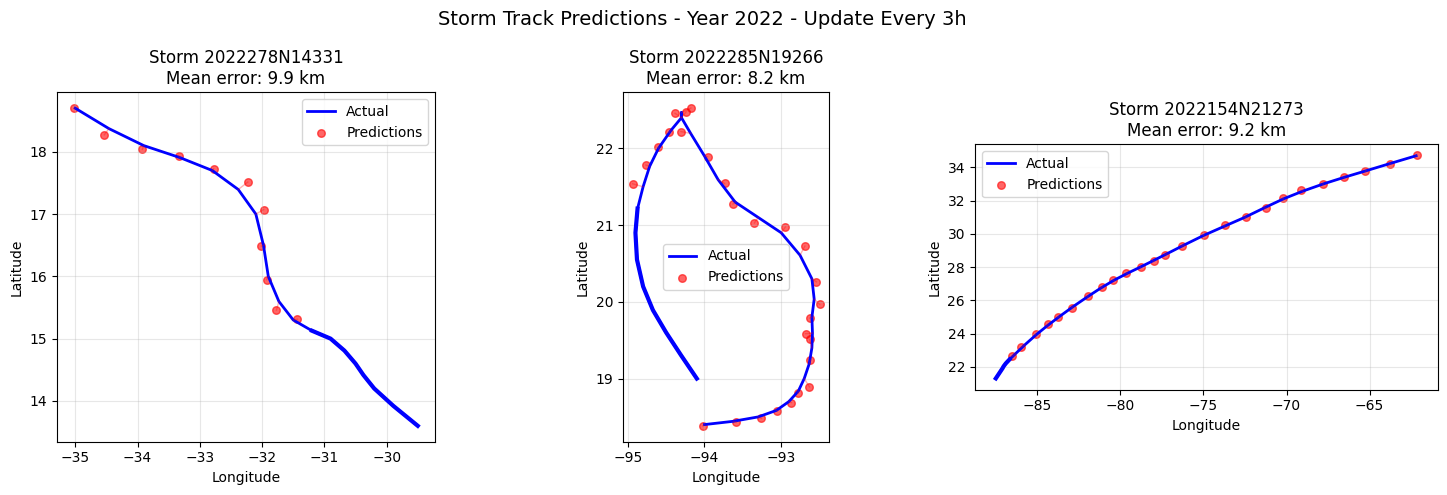

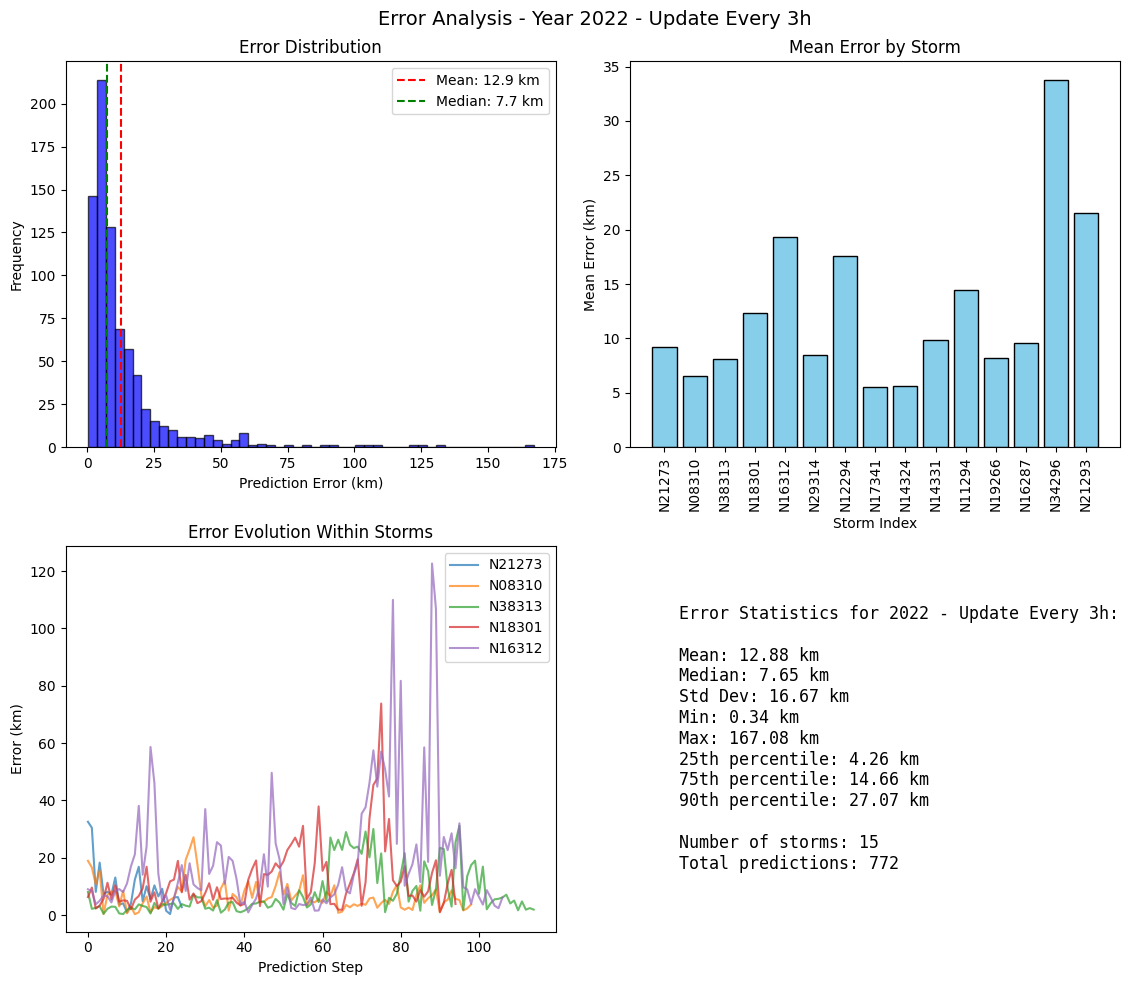

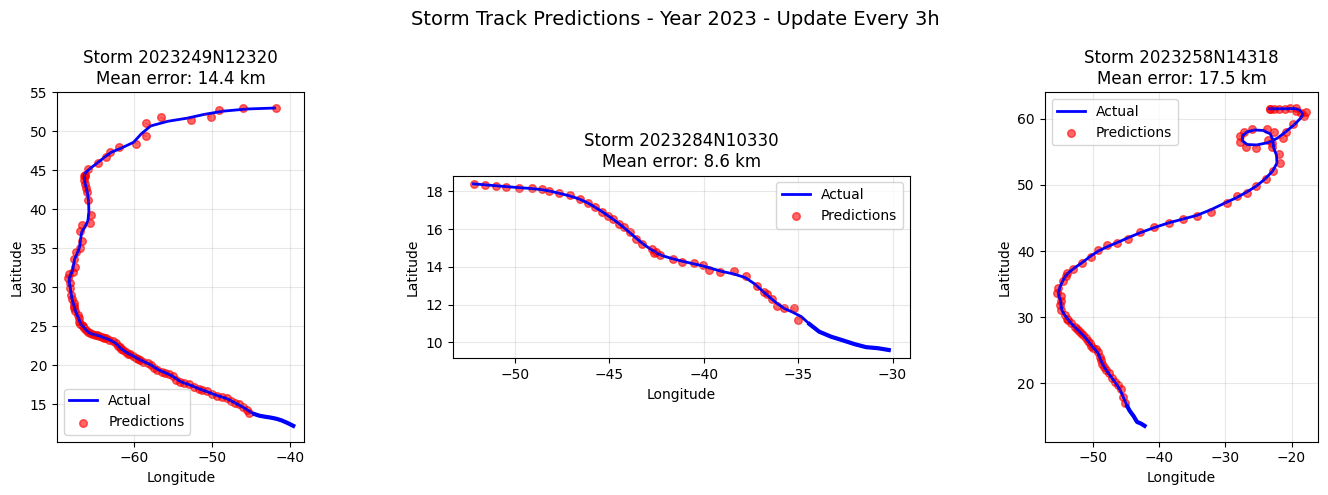

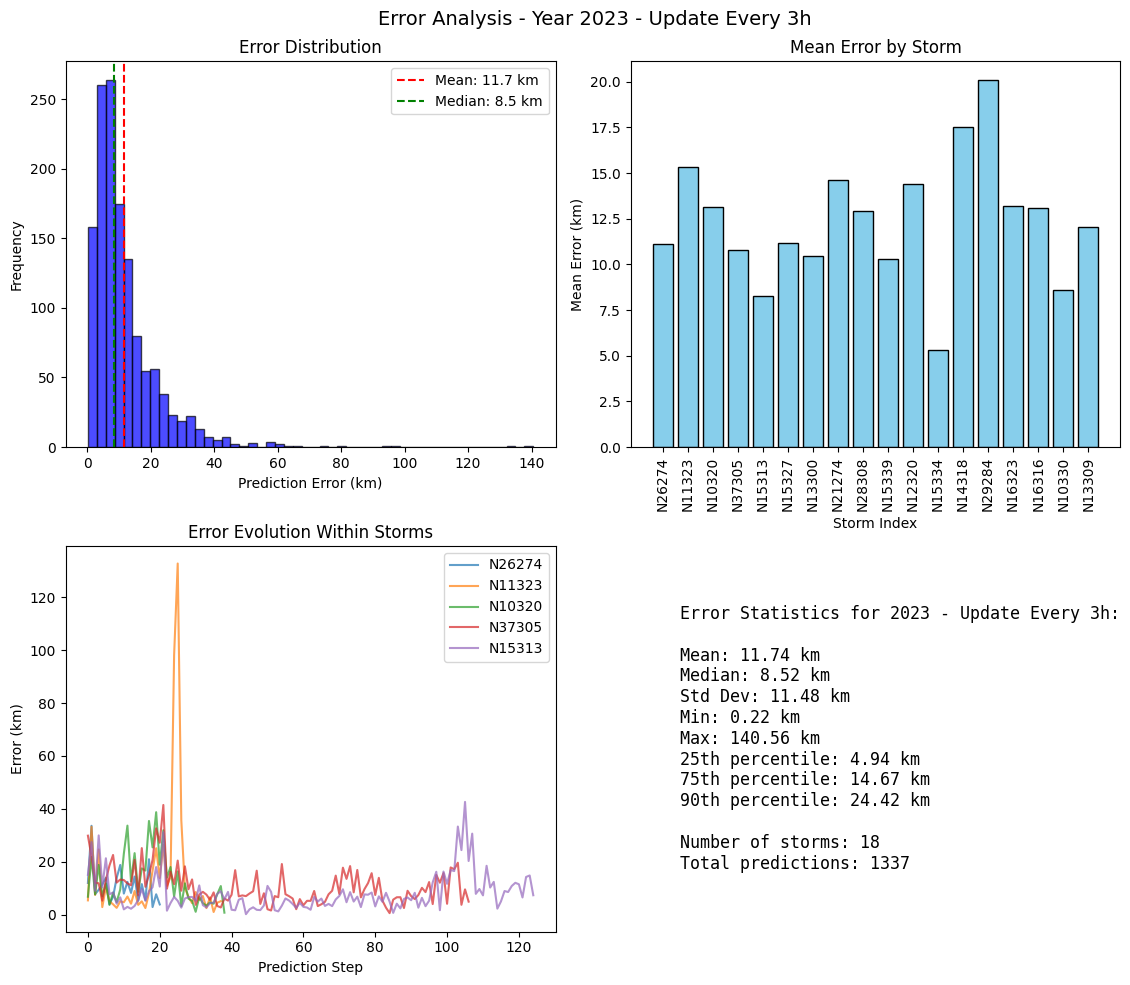



Visualizations for: Update Every 6h


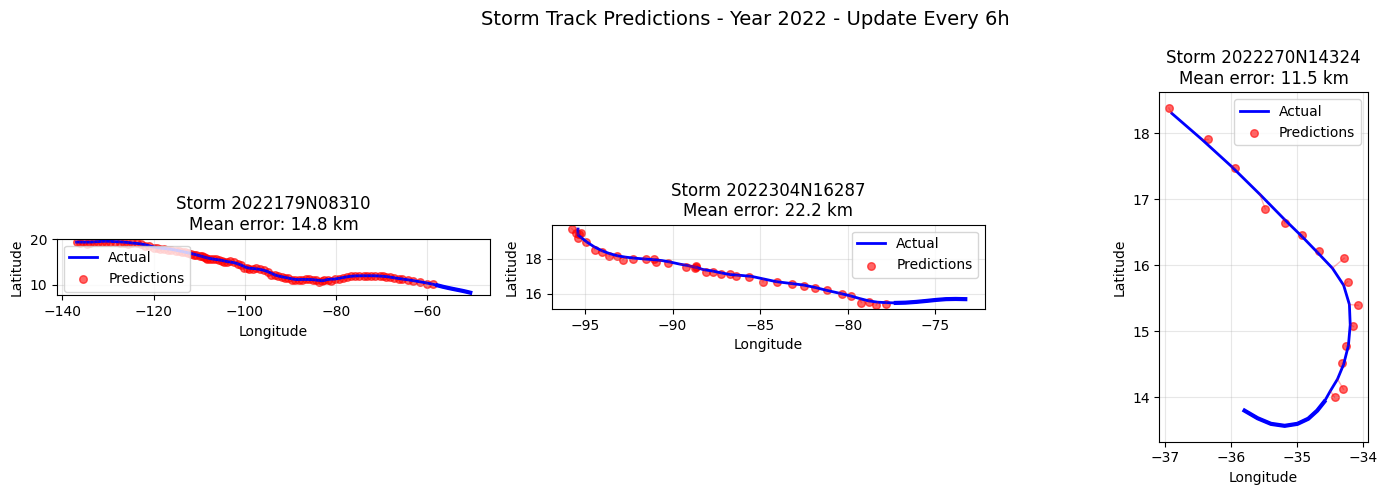

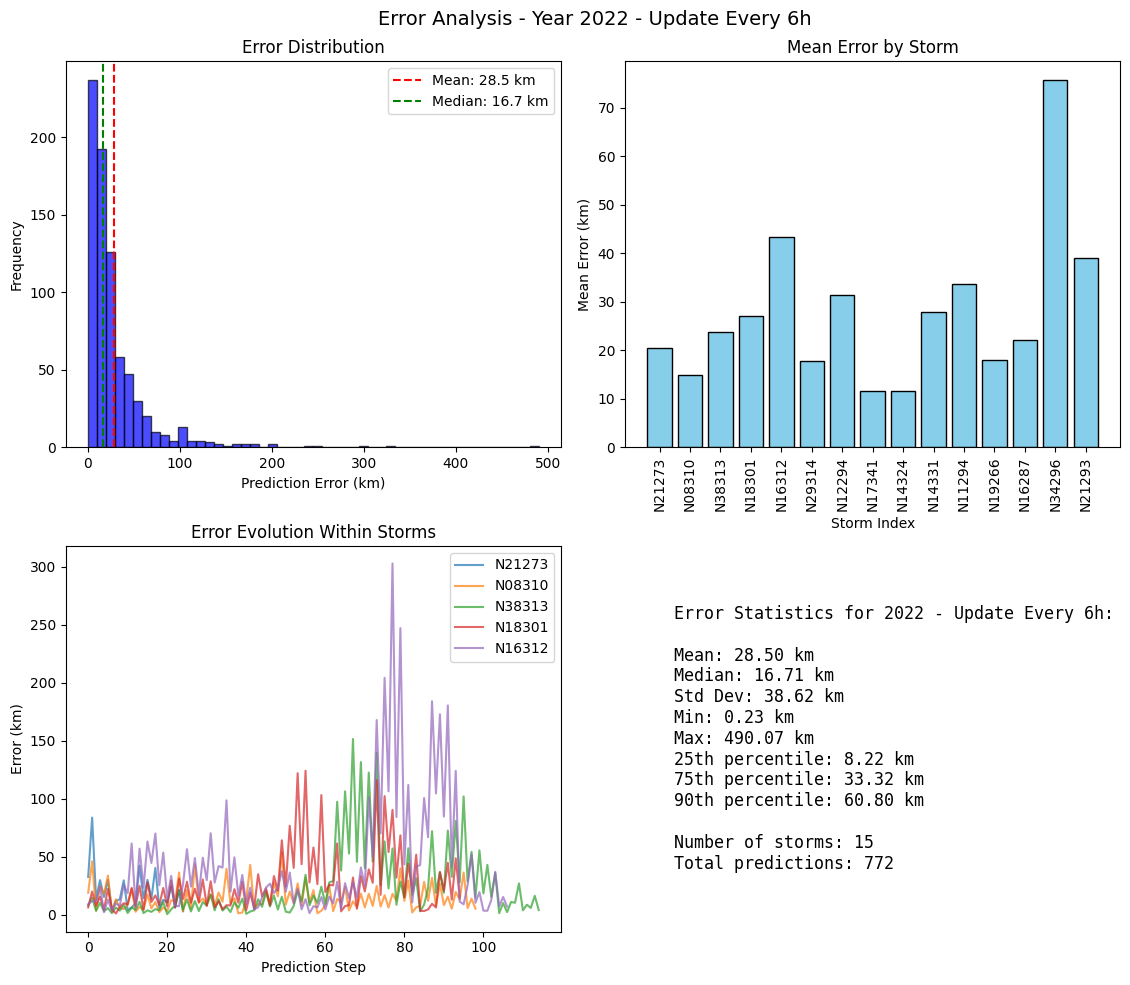

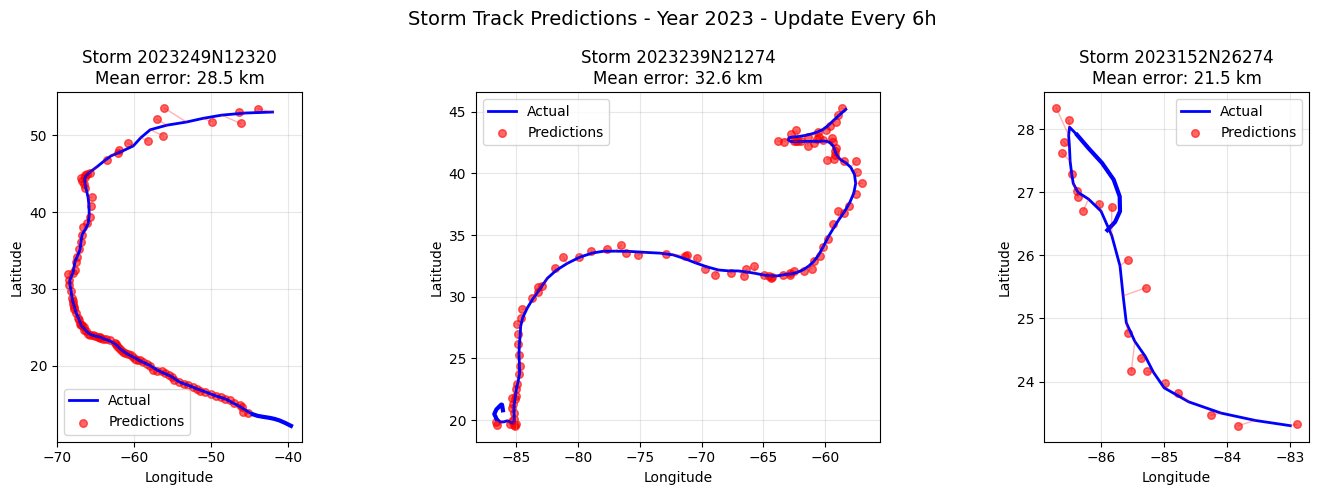

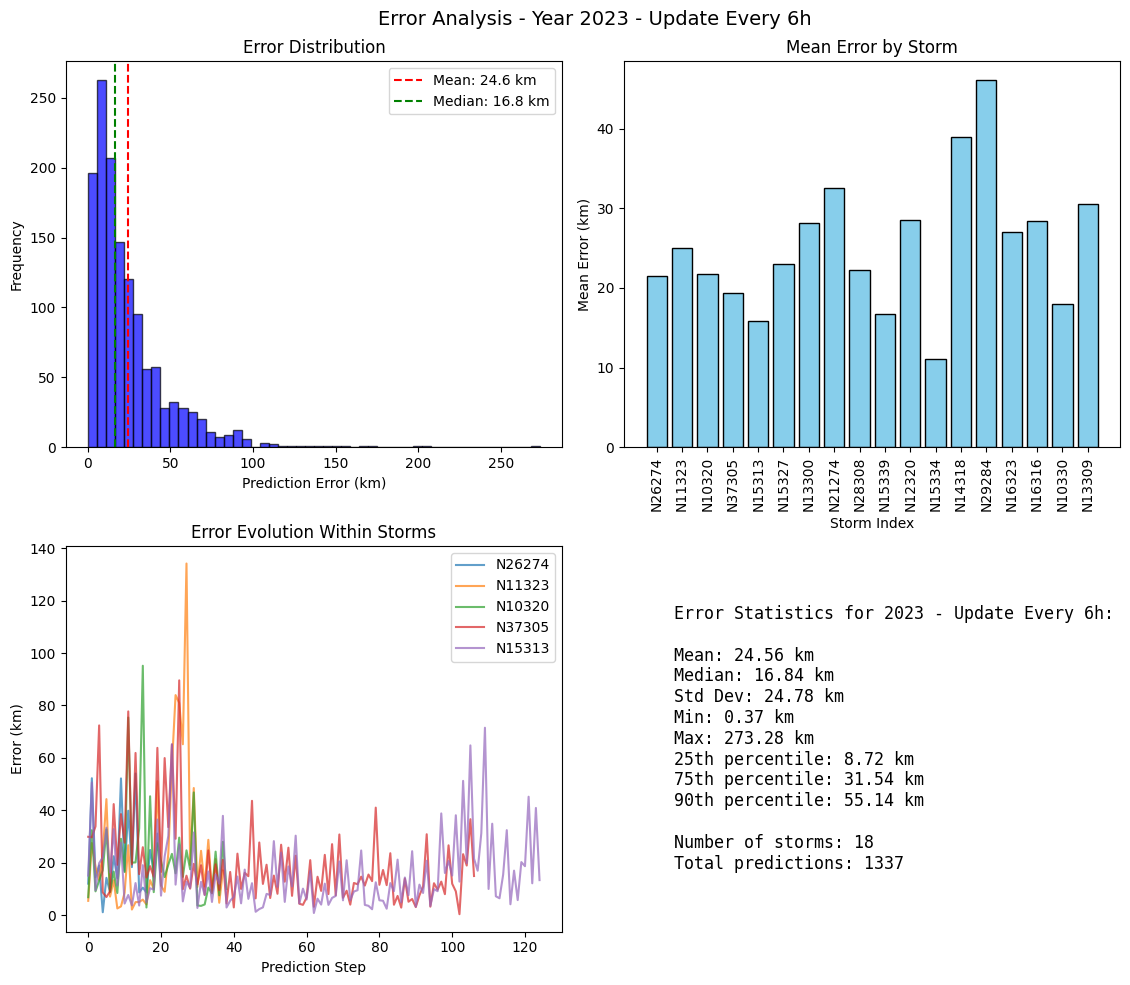



Visualizations for: No Updates


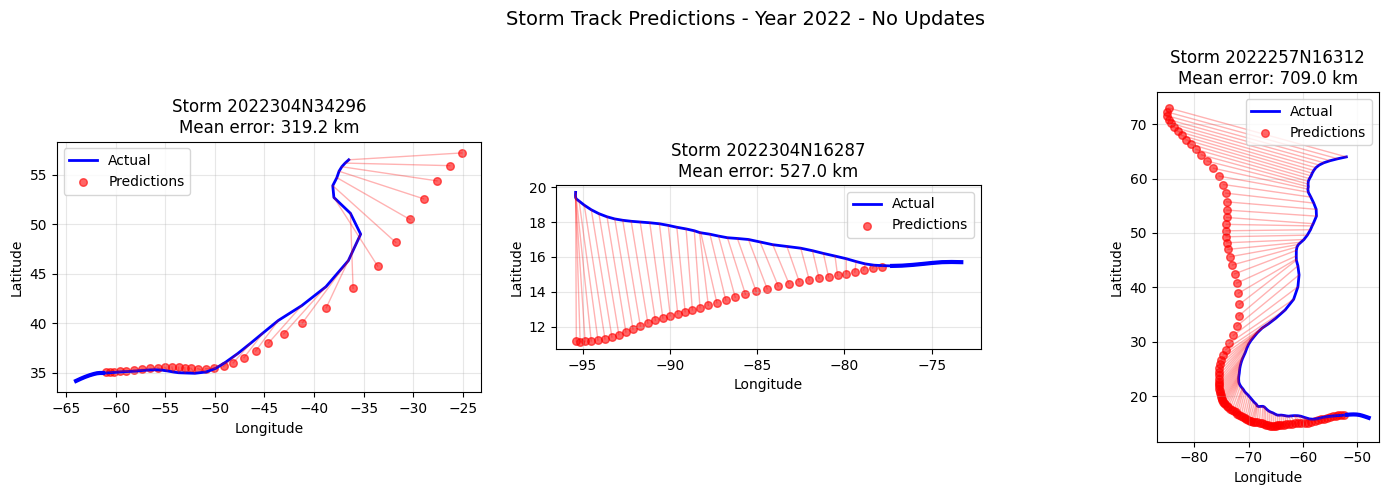

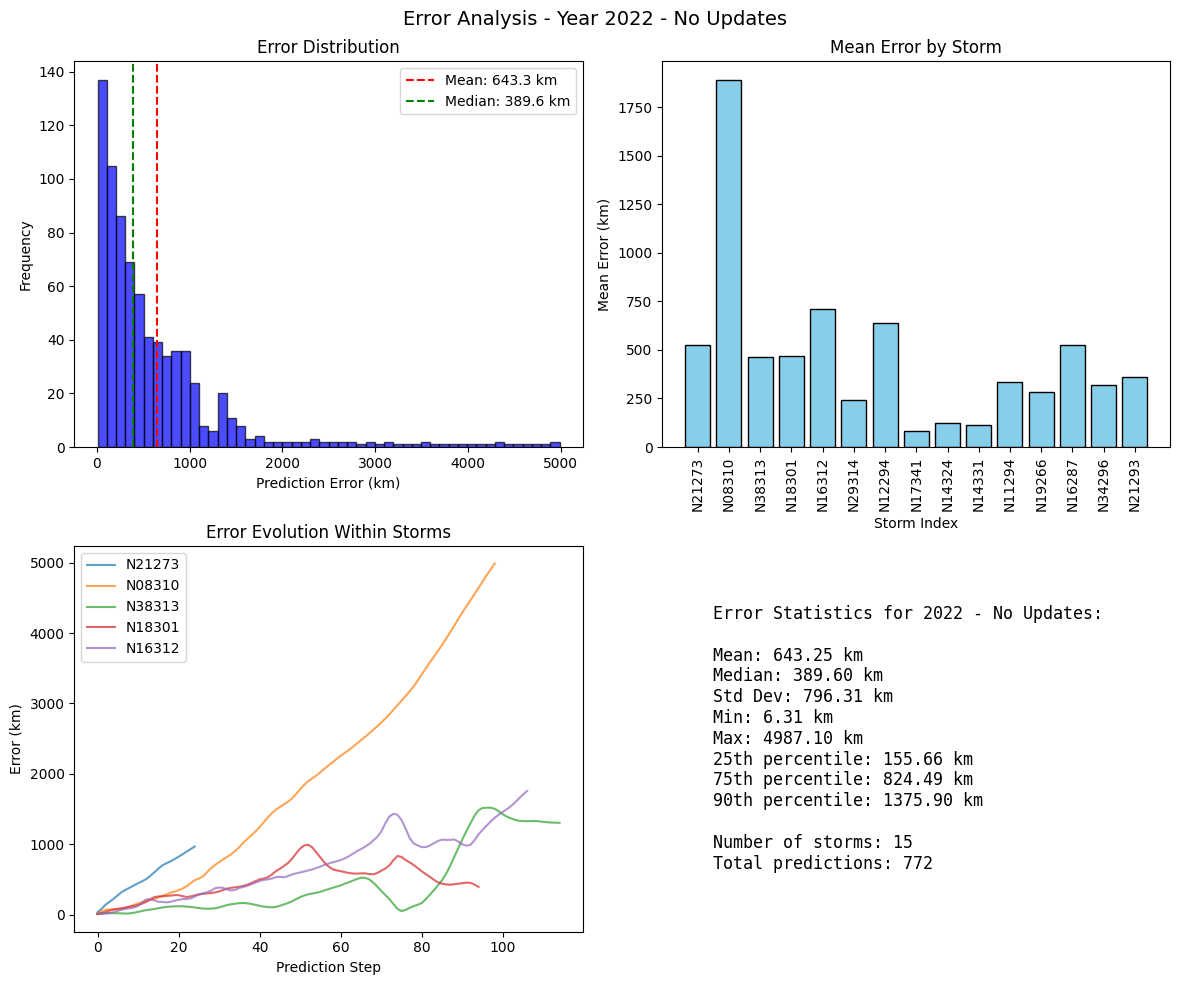

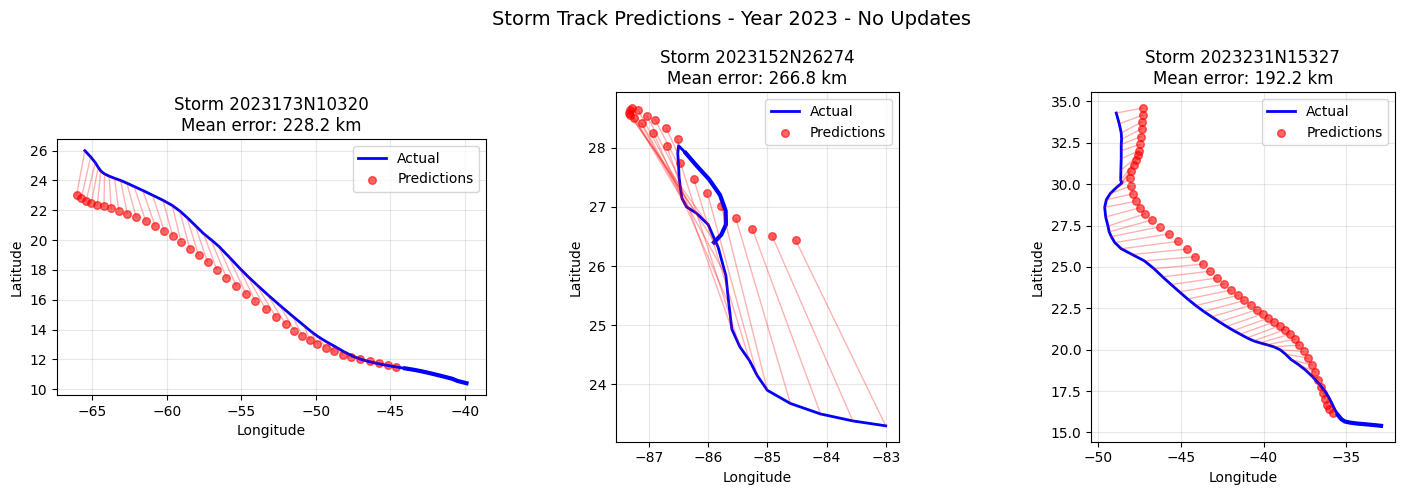

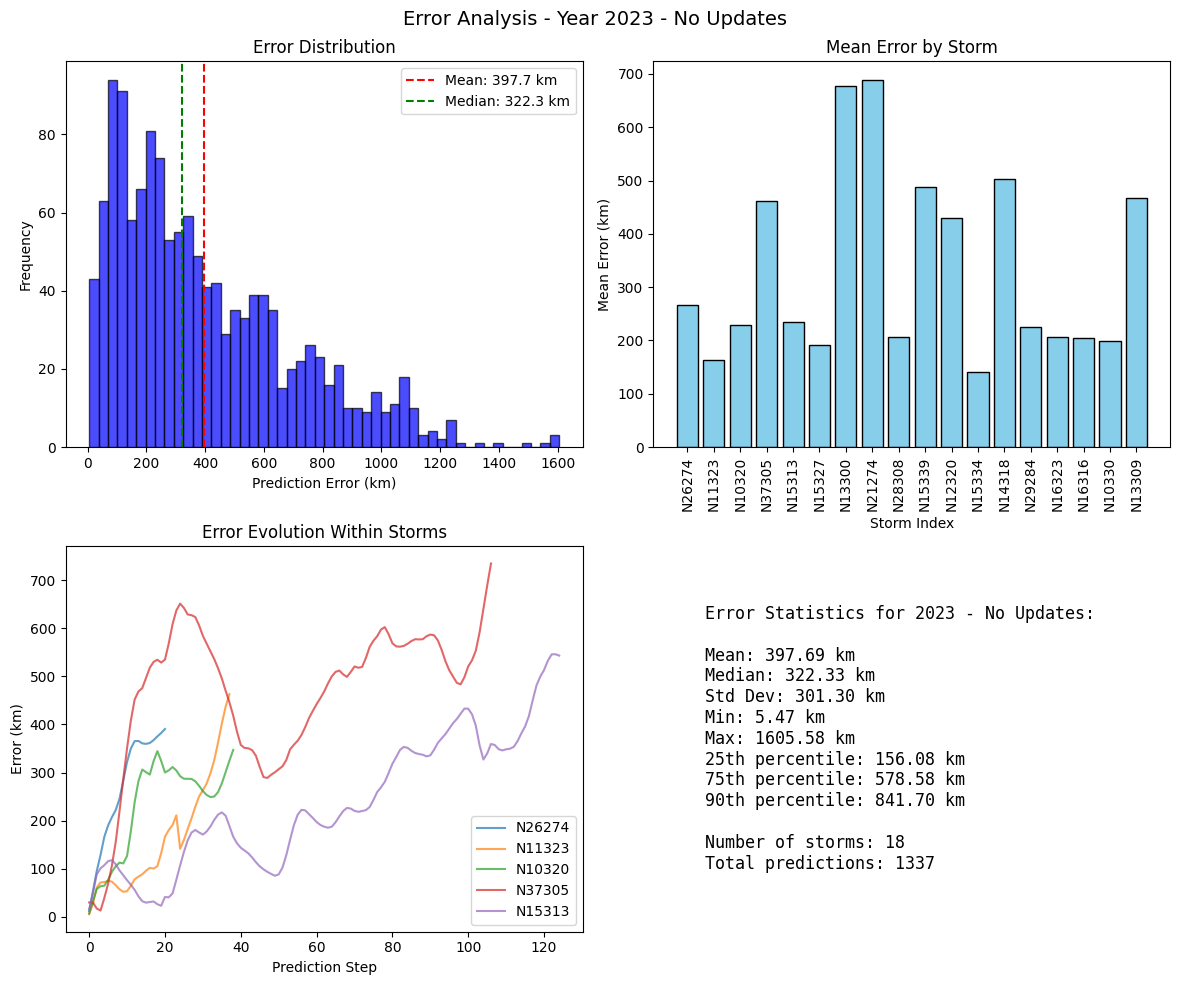

In [36]:
# Visualize predictions and errors for each configuration
np.random.seed(42)
for config in run_configs:
    config_name = config['name']
    config_data = all_results_by_config[config_name]

    print('='*50)
    print(f"Visualizations for: {config_name}")
    print('='*50)

    # Plot predictions for each test year
    for test_year in test_years:
        if test_year not in config_data['errors_by_year']:
            continue

        _, test_sids, _, df_test = loader.split_by_year(test_year)

        # Get the parameters for this specific configuration and year
        params_key = (test_year, config_name)
        if params_key not in optimized_params:
            print(f"Warning: No parameters found for {params_key}")
            continue

        # Create tracker with configuration-specific parameters
        tracker = EKFStormTracker(
            **optimized_params[params_key],
            update_filter=config['update_filter'],
            update_freq=config['update_freq']
        )

        # Select 3 random storms
        selected_sids = np.random.choice(
            test_sids,
            min(3, len(test_sids)),
            replace=False
        )

        evaluator = PerformanceEvaluator()
        evaluator.plot_predictions(
            tracker,
            df_test,
            selected_sids,
            test_year,
            config_name,
            save_path=f'ekf_predictions_{test_year}_{config_name.replace(" ", "_")}.png'
        )
        print("\n")

        # Plot error analysis
        evaluator.plot_error_analysis(
            config_data['errors_by_year'][test_year],
            test_year,
            config_name,
            save_path=f'ekf_error_analysis_{test_year}_{config_name.replace(" ", "_")}.png'
        )
        print("\n")

# Results Comparison

In [37]:
def collect_comparison_metrics(all_results_by_config):
    """
    Collect metrics from all configurations for comparison

    Returns:
    --------
    dict with config_names, mae_by_config, rmse_by_config, p90_by_config
    """
    config_names = []
    mae_by_config = []
    rmse_by_config = []
    p90_by_config = []

    for config_name, config_data in all_results_by_config.items():
        results = config_data['results']
        if results:
            config_names.append(config_name)
            mae_by_config.append(np.mean([r['window_mae_km'] for r in results]))
            rmse_by_config.append(np.mean([r['window_rmse_km'] for r in results]))
            p90_by_config.append(np.mean([r['p90_error_km'] for r in results]))

    return {
        'config_names': config_names,
        'mae': mae_by_config,
        'rmse': rmse_by_config,
        'p90': p90_by_config
    }

In [38]:
def plot_average_metrics(ax, metrics):
    """Create bar plot of average error metrics by configuration"""
    x = np.arange(len(metrics['config_names']))
    width = 0.25

    ax.bar(x - width, metrics['mae'], width, label='MAE', color='skyblue')
    ax.bar(x, metrics['rmse'], width, label='RMSE', color='lightcoral')
    ax.bar(x + width, metrics['p90'], width, label='90th Percentile', color='lightgreen')

    ax.set_xlabel('Configuration')
    ax.set_ylabel('Error (km)')
    ax.set_title('Average Error Metrics by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics['config_names'], rotation=15)
    ax.legend()
    ax.grid(True, alpha=0.3)

In [39]:
def plot_error_growth(ax, all_results_by_config, max_hours=72):
    """Plot error growth over time for each configuration"""
    for config_name, config_data in all_results_by_config.items():
        step_averages = compute_error_by_step(config_data)

        if step_averages:
            hours = np.arange(len(step_averages)) * 3  # Convert to hours
            ax.plot(hours, step_averages, label=config_name, linewidth=2)

    ax.set_xlabel('Forecast Time (hours)')
    ax.set_ylabel('Average Error (km)')
    ax.set_title('Error Growth Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, max_hours)

In [40]:
def compute_error_by_step(config_data):
    """Compute average error at each prediction step"""
    max_steps = 0

    # Find maximum number of steps
    for year_errors in config_data['errors_by_year'].values():
        for storm_errors in year_errors.values():
            max_steps = max(max_steps, len(storm_errors))

    # Compute average at each step
    step_averages = []
    for step in range(max_steps):
        step_errors = []
        for year_errors in config_data['errors_by_year'].values():
            for storm_errors in year_errors.values():
                if step < len(storm_errors):
                    step_errors.append(storm_errors[step])
        if step_errors:
            step_averages.append(np.mean(step_errors))

    return step_averages

In [41]:
def extract_all_errors(config_data):
    """Extract all errors from a configuration's results"""
    all_errors = []
    for year_errors in config_data['errors_by_year'].values():
        for storm_errors in year_errors.values():
            all_errors.extend(storm_errors)
    return all_errors

In [42]:
def plot_error_distributions(ax, all_results_by_config):
    """Create box plot of error distributions by configuration"""
    error_data_for_box = []
    labels_for_box = []

    for config_name, config_data in all_results_by_config.items():
        all_errors = extract_all_errors(config_data)
        if all_errors:
            error_data_for_box.append(all_errors)
            labels_for_box.append(config_name)

    ax.boxplot(error_data_for_box, labels=labels_for_box)
    ax.set_ylabel('Error (km)')
    ax.set_title('Error Distribution by Configuration')
    ax.grid(True, alpha=0.3)

In [43]:
def create_summary_table(ax, all_results_by_config, metrics):
    """Create summary table with performance metrics"""
    ax.axis('off')

    table_data = []
    headers = [
        'Configuration',
        'MAE (km)',
        'RMSE (km)',
        '90th % (km)',
        'Max (km)'
    ]

    for i, config_name in enumerate(metrics['config_names']):
        config_data = all_results_by_config[config_name]
        all_errors = extract_all_errors(config_data)

        if all_errors:
            row = [
                config_name,
                f"{metrics['mae'][i]:.1f}",
                f"{metrics['rmse'][i]:.1f}",
                f"{metrics['p90'][i]:.1f}",
                f"{np.max(all_errors):.1f}"
            ]
            table_data.append(row)

    table = ax.table(
        cellText=table_data,
        colLabels=headers,
        loc='center',
        cellLoc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)

    ax.set_title('Performance Summary', pad=20)

In [44]:
def create_performance_comparison_plot(
    all_results_by_config,
    save_path='ekf_performance_comparison.png'
):
    """Create comprehensive performance comparison figure"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Collect metrics
    metrics = collect_comparison_metrics(all_results_by_config)

    # Create individual plots
    plot_average_metrics(axes[0, 0], metrics)
    plot_error_growth(axes[0, 1], all_results_by_config)
    plot_error_distributions(axes[1, 0], all_results_by_config)
    create_summary_table(axes[1, 1], all_results_by_config, metrics)

    plt.suptitle('EKF Storm Tracking Performance Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    return metrics

In [45]:
def print_performance_summary(metrics):
    """Print detailed performance comparison summary"""
    print("Performance Comparison:")
    print("-" * 80)
    print(f"{'Configuration':<30} {'MAE (km)':<12} {'RMSE (km)':<12} {'90th % (km)':<12}")
    print("-" * 80)

    for i, config_name in enumerate(metrics['config_names']):
        print(f"{config_name:<30} {metrics['mae'][i]:<12.2f} {metrics['rmse'][i]:<12.2f} {metrics['p90'][i]:<12.2f}")

    # Calculate performance degradation
    if len(metrics['config_names']) >= 2:
        print("\nPerformance Degradation:")
        baseline_mae = metrics['mae'][0]  # Update Every 3h
        for i in range(1, len(metrics['config_names'])):
            degradation = ((metrics['mae'][i] - baseline_mae) / baseline_mae) * 100
            print(f"{metrics['config_names'][i]} vs. {metrics['config_names'][0]}: {degradation:+.1f}%")

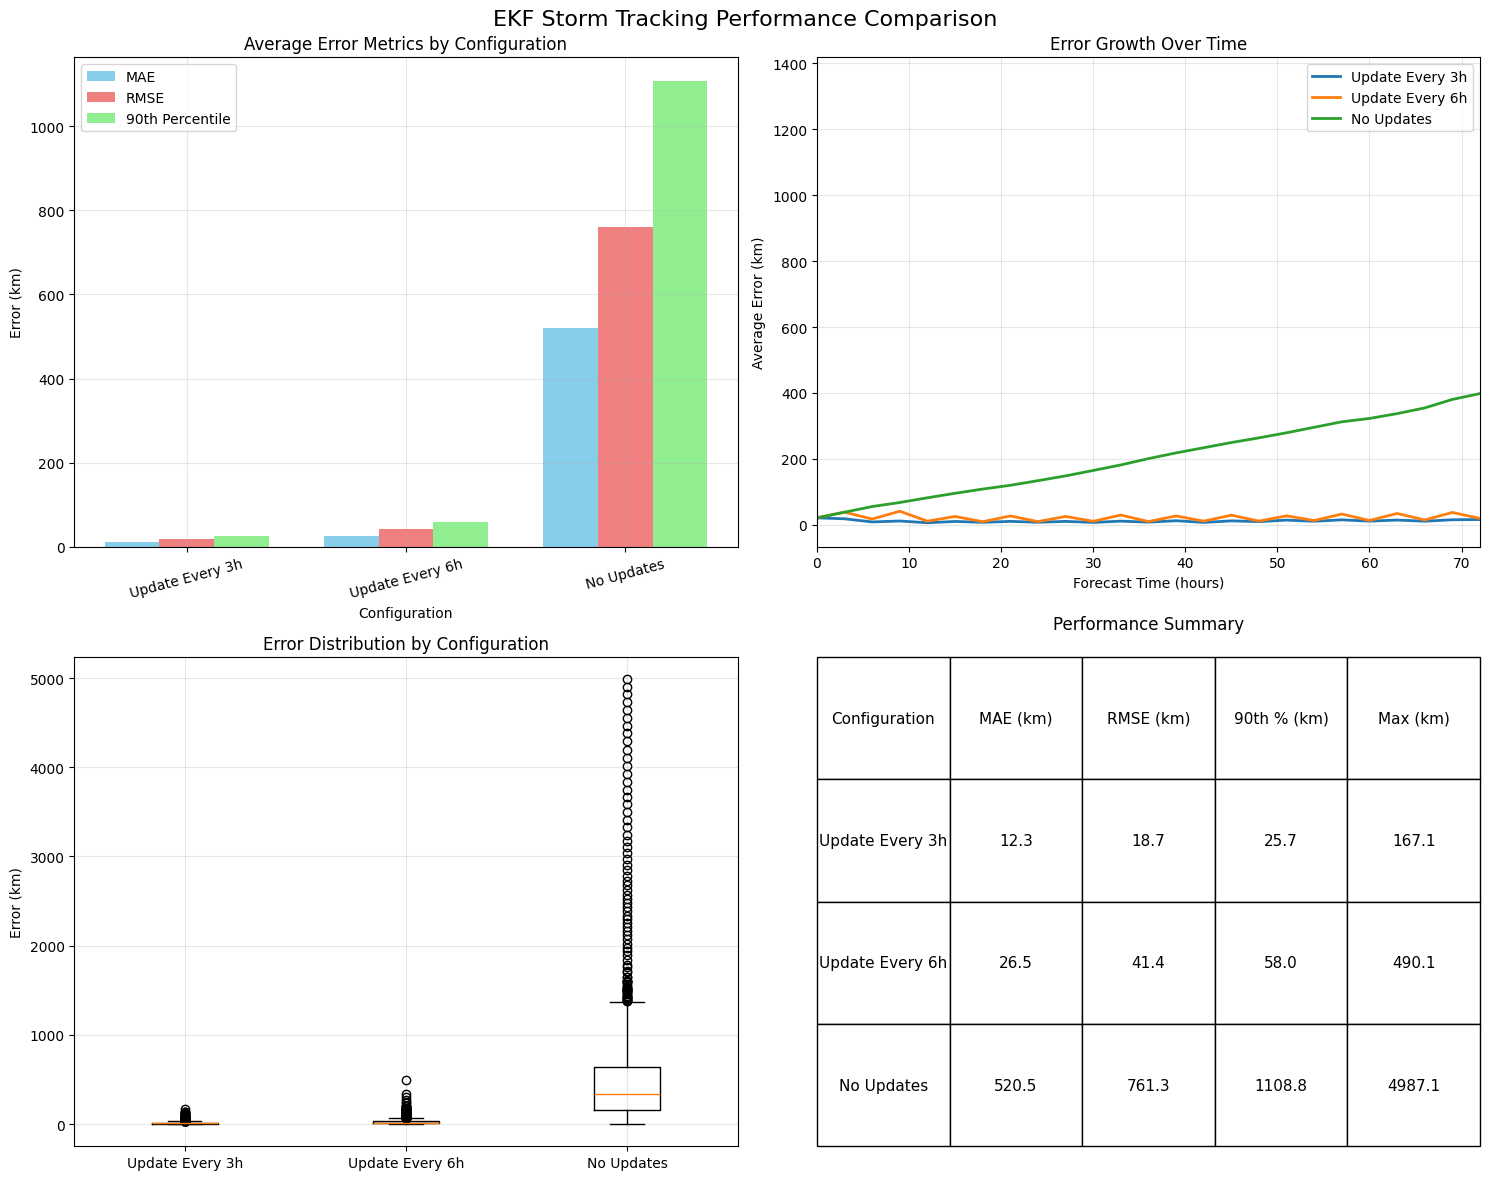



Performance Comparison:
--------------------------------------------------------------------------------
Configuration                  MAE (km)     RMSE (km)    90th % (km) 
--------------------------------------------------------------------------------
Update Every 3h                12.31        18.74        25.75       
Update Every 6h                26.53        41.44        57.97       
No Updates                     520.47       761.30       1108.80     

Performance Degradation:
Update Every 6h vs. Update Every 3h: +115.5%
No Updates vs. Update Every 3h: +4128.1%


In [46]:
# Run performance comparison
comparison_metrics = create_performance_comparison_plot(all_results_by_config)
print("\n")
print_performance_summary(comparison_metrics)

# Results Saving

In [47]:
# Save production parameters (average per configuration)
production_params = {}

for config in run_configs:
    config_params = []

    # Collect all parameters for this specific configuration
    for test_year in test_years:
        params_key = (test_year, config['name'])
        if params_key in optimized_params:
            params = optimized_params[params_key]
            config_params.append([
                params['q_pos'], params['q_vel'],
                params['q_acc'], params['r_pos']
            ])

    # Average parameters for this configuration across years
    if config_params:
        avg_params = np.mean(config_params, axis=0)
        production_params[config['name']] = {
            'q_pos': avg_params[0],
            'q_vel': avg_params[1],
            'q_acc': avg_params[2],
            'r_pos': avg_params[3]
        }
        print(f"Production parameters for {config['name']}:")
        print(f"  q_pos: {avg_params[0]:.1f} km^2")
        print(f"  q_vel: {avg_params[1]:.1f} (km/h)^2")
        print(f"  q_acc: {avg_params[2]:.1f} (km/h^2)^2")
        print(f"  r_pos: {avg_params[3]:.1f} km^2\n")

Production parameters for Update Every 3h:
  q_pos: 1.0 km^2
  q_vel: 36.0 (km/h)^2
  q_acc: 25.0 (km/h^2)^2
  r_pos: 16.0 km^2

Production parameters for Update Every 6h:
  q_pos: 25.0 km^2
  q_vel: 49.0 (km/h)^2
  q_acc: 9.0 (km/h^2)^2
  r_pos: 37.0 km^2

Production parameters for No Updates:
  q_pos: 9.0 km^2
  q_vel: 25.0 (km/h)^2
  q_acc: 16.0 (km/h^2)^2
  r_pos: 16.0 km^2



In [48]:
# Save a parameter summary CSV
param_summary = []
for (year, config_name), params in optimized_params.items():
    param_summary.append({
        'year': year,
        'configuration': config_name,
        'q_pos': params['q_pos'],
        'q_vel': params['q_vel'],
        'q_acc': params['q_acc'],
        'r_pos': params['r_pos']
    })

param_df = pd.DataFrame(param_summary)
param_df.to_csv('ekf_optimized_parameters.csv', index=False)
print("Parameter summary saved to 'ekf_optimized_parameters.csv'")

Parameter summary saved to 'ekf_optimized_parameters.csv'


In [49]:
# Save all results for future analysis
saved_objects = {
    'optimized_parameters': optimized_params,
    'production_parameters': production_params,
    'all_results_by_config': all_results_by_config,
    'test_years': test_years,
    'run_configurations': run_configs
}

joblib.dump(saved_objects, 'ekf_saved_objects.joblib')
print("Objects saved to 'ekf_saved_objects.joblib'")

Objects saved to 'ekf_saved_objects.joblib'


In [50]:
# Save summary results as CSV
all_results = []
for config_name, config_data in all_results_by_config.items():
    for result in config_data['results']:
        result_copy = result.copy()
        result_copy['configuration'] = config_name
        all_results.append(result_copy)

results_df = pd.DataFrame(all_results)
results_df.to_csv('ekf_all_results_comparison.csv', index=False)
print("Results summary saved to 'ekf_all_results_comparison.csv'")

Results summary saved to 'ekf_all_results_comparison.csv'
